# Business Context

**The Blocker Fraud Company**

The Blocker Fraud Company is a company specialized in detecting fraud in financial transactions made through mobile devices. The company has a service called “Blocker Fraud” in which it guarantees the blocking of fraudulent transactions.

And the business model of the company is of the Service type with the monetization made by the performance of the service provided, that is, the user pays a fixed fee on the success in detecting fraud in the customer's transactions.

However, the Blocker Fraud Company is expanding in Brazil and to acquire customers more quickly, it has adopted a very aggressive strategy. The strategy works as follows:

 * The company will receive 25% of the value of each transaction that is truly detected as fraud.
 * The company will receive 5% of the value of each transaction detected as fraud, but the transaction is truly legitimate.
 * The company will return 100% of the value to the customer, for each transaction detected as legitimate, however the transaction is truly a fraud.
 * With this aggressive strategy, the company assumes the risks of failing to detect fraud and is remunerated for assertive fraud detection.

For the client, it is an excellent business to hire the Blocker Fraud Company. Although the fee charged is very high on success, 25%, the company reduces its costs with fraudulent transactions correctly detected and the damage caused by an error in the anti-fraud service will be covered by the Blocker Fraud Company itself.

For the company, in addition to getting many customers with this risky strategy to guarantee reimbursement in the event of a failure to detect customer fraud, it depends only on the precision and accuracy of the models built by its Data Scientists, that is, how much the more accurate the “Blocker Fraud” model, the greater the company's revenue. However, if the model has low accuracy, the company could have a huge loss.

**The challenge**

You have been hired as a Data Science Consultant to create a model of high precision and accuracy in detecting fraud of transactions made through mobile devices.

At the end of your consultancy, you need to deliver to the CEO of Blocker Fraud Company a model in production in which your access will be made via API, that is, customers will send their transactions via API so that your model classifies them as fraudulent or legitimate.

In addition, you will need to submit a report reporting your model's performance and results in relation to the profit and loss that the company will have when using the model you produced. Your report should contain the answers to the following questions:

* What is the model's Precision and Accuracy?
* How Reliable is the model in classifying transactions as legitimate or fraudulent?
* What is the Expected Billing by the Company if we classify 100% of transactions with the model?
* What is the Loss Expected by the Company in case of model failure?
* What is the Profit Expected by the Blocker Fraud Company when using the model?

# 0.0 Imports

## 0.1. Imports

In [1]:
import pandas  as pd
import seaborn as sns
import xgboost as xgb
import random  as rd
import numpy as np

from matplotlib       import pyplot          as plt
from sklearn          import metrics         as m
from sklearn          import model_selection as ms    
from scikitplot       import metrics         as mt
from scipy            import stats           as ss
from sklearn          import preprocessing   as pp
from imblearn         import combine         as c

from sklearn.ensemble  import RandomForestClassifier
from sklearn.ensemble  import RandomForestRegressor
from sklearn           import linear_model
from category_encoders import TargetEncoder
from IPython.display   import Image
from boruta            import BorutaPy

import pickle
import warnings
warnings.filterwarnings("ignore")

## 0.2. Helper Functions

### 0.2.1. pyplot's graphics parameters

In [14]:
#função para deixar os graficos melhores visualmente
%matplotlib inline
%pylab inline
plt.style.use( 'bmh' )
plt.rcParams['figure.figsize'] = [25, 12]
plt.rcParams['font.size'] = 24
#display( HTML( '<style>.container { width:100% !important; }</style>') )
pd.options.display.max_columns = None
pd.options.display.max_rows = None
pd.set_option( 'display.expand_frame_repr', False )
sns.set()

Populating the interactive namespace from numpy and matplotlib


### 0.2.3 Plots

#### 0.2.3.1. Metricals plots

In [15]:
def numerical_metrics(numerical_attributes):
    #ct = central tendency
    ct_mean = pd.DataFrame(numerical_attributes.apply(np.mean)).T
    ct_median = pd.DataFrame(numerical_attributes.apply(np.median)).T

    #d = dispersion
    d_std = pd.DataFrame(numerical_attributes.apply(np.std)).T
    d_min = pd.DataFrame(numerical_attributes.apply(min)).T
    d_max = pd.DataFrame(numerical_attributes.apply(max)).T
    d_range = pd.DataFrame(numerical_attributes.apply(lambda x: x.max() - x.min())).T
    d_skew = pd.DataFrame(numerical_attributes.apply(lambda x: x.skew())).T
    d_kurtosis = pd.DataFrame(numerical_attributes.apply(lambda x: x.kurtosis())).T

    na_resume = pd.concat([d_min,d_max,d_range,ct_mean,ct_median,d_std,d_skew,d_kurtosis]).T.reset_index()
    na_resume.columns=['Attributes','Min','Max','Range','Mean','Median','STD','Skew','Kurtosis']

    return na_resume

In [2]:
def model_metrics(model,y_val,yhat,verbose =1):
    
    model = pd.DataFrame([model]).T
    
    #Accuracy
    acc = m.accuracy_score(y_val,yhat)
    accdf = pd.DataFrame([acc]).T

    #Balanced Accuracy
    balanced= m.balanced_accuracy_score(y_val,yhat)
    balanceddf = pd.DataFrame([balanced]).T

    #Kappa Metrics
    kappa= m.cohen_kappa_score(y_val, yhat)
    kappadf = pd.DataFrame([kappa]).T

    #Precision Score
    precision= m.precision_score(y_val, yhat)
    precisiondf = pd.DataFrame([precision]).T
    
    #Recall Score
    recall= m.recall_score(y_val, yhat)
    recalldf = pd.DataFrame([recall]).T
    
    #F1 Score
    f1= m.f1_score(y_val, yhat)
    f1df = pd.DataFrame([f1]).T

    
    metrics = pd.concat([model,accdf,balanceddf,kappadf,precisiondf,recalldf,f1df]).T.reset_index()
    metrics.columns=['Index','Model','Accuracy','Balanced Accuracy','Kappa Score','Precision Score','Recall Score','F1 Score']
    metrics.drop(['Index'],axis=1)
    if verbose ==1:
        print('Accuracy: {}'.format(acc))
        print('Balanced Accuracy: {}'.format(balanced))
        print('Kappa Score: {}'.format(kappa))
        print('Precision Score: {}'.format(recall))
        print('Recall Score: {}'.format(recall))
        print('F1 Score: {}'.format(f1))
        #Classification Report
        print(m.classification_report(y_val,yhat))
        # Confision Matrix
        mt.plot_confusion_matrix(y_val,yhat,normalize=False,figsize=(12,12))
        
    return metrics

### 0.2.4. Supressed Notation

In [3]:
np.set_printoptions(suppress=True)
pd.set_option('display.float_format', lambda x: '%.4f' % x)

## 0.3. Data Summary

**step** - maps a unit of time in the real world. In this case 1 step is 1 hour of time. Total steps 744 (30 days simulation).

**type** - CASH-IN, CASH-OUT, DEBIT, PAYMENT and TRANSFER.

**amount** - amount of the transaction in local currency.

**nameOrig** - customer who started the transaction

**oldbalanceOrg** - initial balance before the transaction

**newbalanceOrig** - new balance after the transaction

**nameDest** - customer who is the recipient of the transaction

**oldbalanceDest** - initial balance recipient before the transaction. Note that there is not information for customers that start with M (Merchants).

**newbalanceDest** - new balance recipient after the transaction. Note that there is not information for customers that start with M (Merchants).

**isFraud** - This is the transactions made by the fraudulent agents inside the simulation. In this specific dataset the fraudulent behavior of the agents aims to profit by taking control or customers accounts and try to empty the funds by transferring to another account and then cashing out of the system.

**isFlaggedFraud** - The business model aims to control massive transfers from one account to another and flags illegal attempts. An illegal attempt in this dataset is an attempt to transfer more than 200.000 in a single transaction.

## 0.4. Loading Data

In [4]:
df_raw=pd.read_csv('..\dataset\PS_20174392719_1491204439457_log.csv',low_memory=True)

In [7]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


# 1.0. Data Description

In [5]:
df_dd=df_raw.copy()

In [9]:
df_dd.head()

step      type     amount     nameOrig  oldbalanceOrg  newbalanceOrig     nameDest  oldbalanceDest  newbalanceDest  isFraud  isFlaggedFraud
0     1   PAYMENT  9839.6400  C1231006815    170136.0000     160296.3600  M1979787155          0.0000          0.0000        0               0
1     1   PAYMENT  1864.2800  C1666544295     21249.0000      19384.7200  M2044282225          0.0000          0.0000        0               0
2     1  TRANSFER   181.0000  C1305486145       181.0000          0.0000   C553264065          0.0000          0.0000        1               0
3     1  CASH_OUT   181.0000   C840083671       181.0000          0.0000    C38997010      21182.0000          0.0000        1               0
4     1   PAYMENT 11668.1400  C2048537720     41554.0000      29885.8600  M1230701703          0.0000          0.0000        0               0

## <s>1.1. Rename Columns</s>

In [25]:
#df_dd=df_dd.rename(columns={'step':'hour'}, inplace = False)

## 1.2. Data Dimensions

In [12]:
print("Number of rows: {}".format(df_dd.shape[0]))
print("Number of columns: {}".format(df_dd.shape[1]))

Number of rows: 6362620
Number of columns: 11


## 1.3. Data Types

In [13]:
df_dd.dtypes

step                int64
type               object
amount            float64
nameOrig           object
oldbalanceOrg     float64
newbalanceOrig    float64
nameDest           object
oldbalanceDest    float64
newbalanceDest    float64
isFraud             int64
isFlaggedFraud      int64
dtype: object

## 1.4. Check NA

In [14]:
df_dd.isna().sum()

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

## <s>1.5. Fill NA </s>

## 1.6. Change Data

In [6]:
df_dd['step']=df_dd['step'].astype(int16)
df_dd['isFraud']=df_dd['isFraud'].astype(int8)
df_dd['isFlaggedFraud']=df_dd['isFlaggedFraud'].astype(int8)

NameError: name 'int16' is not defined

In [16]:
df_dd.dtypes

step                int16
type               object
amount            float64
nameOrig           object
oldbalanceOrg     float64
newbalanceOrig    float64
nameDest           object
oldbalanceDest    float64
newbalanceDest    float64
isFraud              int8
isFlaggedFraud       int8
dtype: object

## 1.7. Check Balanced Data

In [17]:
df_dd['isFraud'].value_counts(normalize=True)

0   0.99871
1   0.00129
Name: isFraud, dtype: float64

## 1.8. Statistical Description

In [ ]:
numerical_attributes=df_dd.select_dtypes(include=['int8','int16','float64'])
categorical_attributes=df_dd.select_dtypes(exclude=['int8','int16','float64'])

### 1.8.1. Numerical Attributes

In [19]:
na_resume=numerical_metrics(numerical_attributes)
na_resume

Attributes     Min             Max           Range          Mean       Median           STD      Skew     Kurtosis
0            step 1.00000       743.00000       742.00000     243.39725    239.00000     142.33196   0.37518      0.32907
1          amount 0.00000  92445516.64000  92445516.64000  179861.90355  74871.94000  603858.18401  30.99395   1797.95671
2   oldbalanceOrg 0.00000  59585040.37000  59585040.37000  833883.10407  14208.00000 2888242.44607   5.24914     32.96488
3  newbalanceOrig 0.00000  49585040.37000  49585040.37000  855113.66858      0.00000 2924048.27317   5.17688     32.06698
4  oldbalanceDest 0.00000 356015889.35000 356015889.35000 1100701.66652 132705.66500 3399179.84587  19.92176    948.67413
5  newbalanceDest 0.00000 356179278.92000 356179278.92000 1224996.39820 214661.44000 3674128.65339  19.35230    862.15651
6         isFraud 0.00000         1.00000         1.00000       0.00129      0.00000       0.03590  27.77954    769.70298
7  isFlaggedFraud 0.00000         1.00000         1.00000       0.00000      0.00000       0.00159 630.60363 397659.06250

**Step** - Have 743 hours of transactions, totalizing 1 month

**Amount** - Between 0 and 92MM, no present negative amount. Mean 180K. Have many outliers

**Is Fraud** - 0,13% of all transactions

**Is Flagged Fraud** - tiny percent of dataset

In [29]:
numerical_attributes.describe()

step        amount  oldbalanceOrg  newbalanceOrig  oldbalanceDest  newbalanceDest      isFraud  isFlaggedFraud
count 6362620.0000  6362620.0000   6362620.0000    6362620.0000    6362620.0000    6362620.0000 6362620.0000    6362620.0000
mean      243.3972   179861.9035    833883.1041     855113.6686    1100701.6665    1224996.3982       0.0013          0.0000
std       142.3320   603858.2315   2888242.6730    2924048.5030    3399180.1130    3674128.9421       0.0359          0.0016
min         1.0000        0.0000         0.0000          0.0000          0.0000          0.0000       0.0000          0.0000
25%       156.0000    13389.5700         0.0000          0.0000          0.0000          0.0000       0.0000          0.0000
50%       239.0000    74871.9400     14208.0000          0.0000     132705.6650     214661.4400       0.0000          0.0000
75%       335.0000   208721.4775    107315.1750     144258.4100     943036.7075    1111909.2500       0.0000          0.0000
max       743.0000 92445516.6400  59585040.3700   49585040.3700  356015889.3500  356179278.9200       1.0000          1.0000

**Amount** - 75% is less 209k, highers values is outliers

**Old Balance Orig** - about 25% of balance have no founds

**New Balance Orig** - about 50% of all transactions clean account balance after transaction

**Old Balance Dest** - about 25% of balance have no founds

**New Balance Dest** - about 25% of balance have no founds after transaction

### 1.8.2. Categorical Attributes

In [20]:
categorical_attributes.describe()

type     nameOrig     nameDest
count    6362620      6362620      6362620
unique         5      6353307      2722362
top     CASH_OUT  C1902386530  C1286084959
freq     2237500            3          113

**Type** - 5 transactions types 

**Name Orig** - lower frequently transactions

**Name Dest** - more frequently transactions

# 2.0. Feature Engieneering

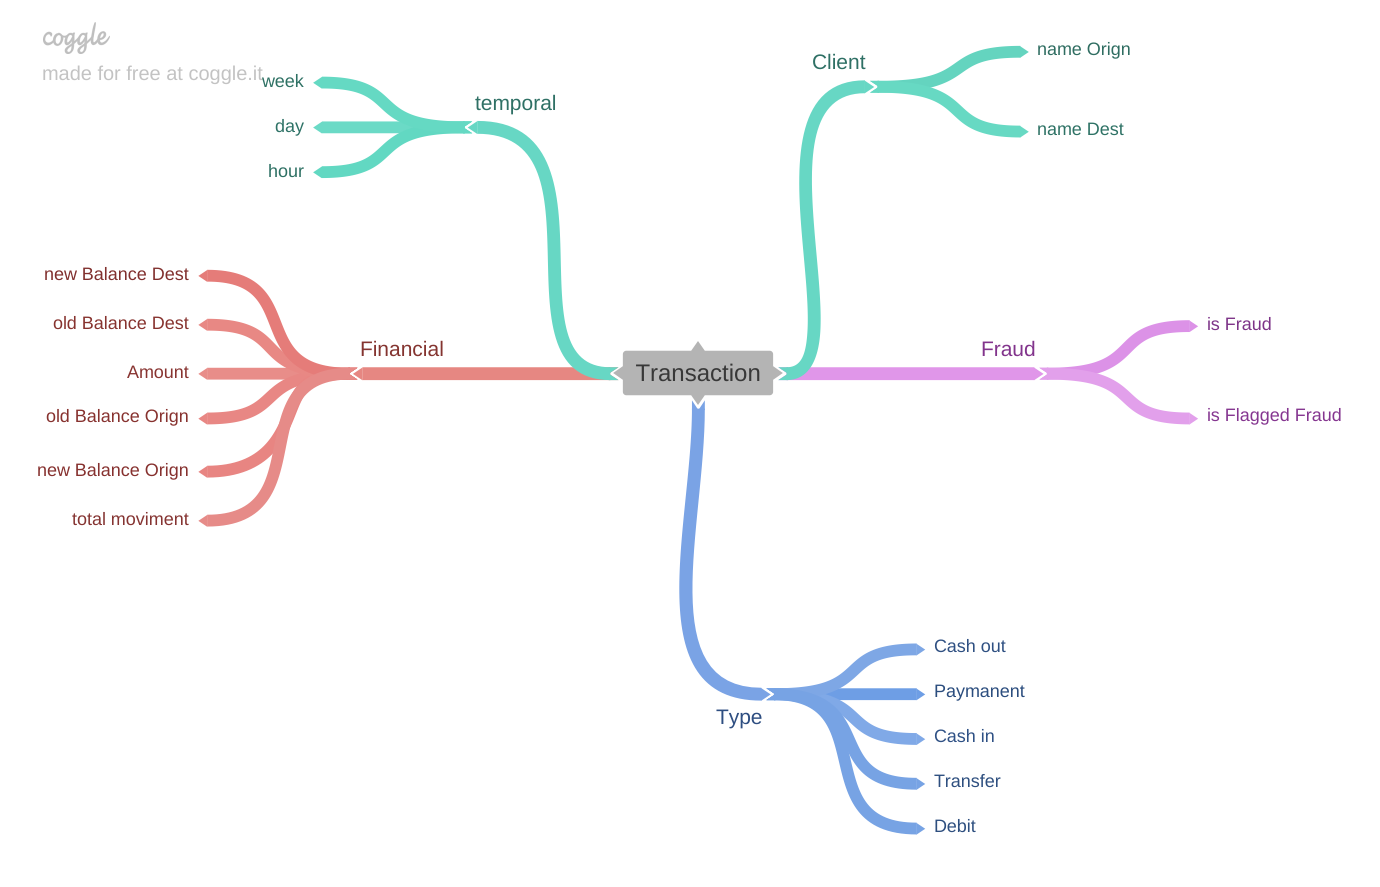

In [35]:
Image('../images/hypothesesMindMap.png')

## 2.1. Hypotheses Criation

**H1** - Most Frauds occurs between days 5 and 15

**H2** - Most Frauds occurs on afternoon

**H3** - Most Frauds occurs on month's second week

**H4** - Most Frauds occurs on Transfer Transactions

## 2.2. Hypotheses Final List

## 2.3. Feature Engieneering

In [8]:
df_fe=df_dd.copy()

In [9]:
df_fe['week']=df_fe['step'].apply(lambda x: np.ceil(x/24/7).astype(int))
df_fe['day']=df_fe['step'].apply(lambda x: np.ceil(x/24).astype(int))
df_fe['hour']=df_fe['step'].apply(lambda x: ((x/24)-np.floor(x/24))*24).astype(int)
df_fe['origType']=df_fe['nameOrig'].apply(lambda x: x[:1])
df_fe['nameOrigNumber']=df_fe['nameOrig'].apply(lambda x: x[1:]).astype(int)
df_fe['destType']=df_fe['nameDest'].apply(lambda x: x[:1])
df_fe['nameDestNumber']=df_fe['nameDest'].apply(lambda x: x[1:]).astype(int)

**week** - Transform hour of month information in week of month

**day** - Transform hour of month  information in day of month

**hour** - Transform hour of month information in hour of day

**origType** - Transform customer name information in customer type to another feature

**nameOrigNumber** - Transform customer name information in customer id

**destType** - Transform customer name information in customer type to another feature

**nameDestNumber** - Transform customer name information in customer id

In [10]:
#Checking if balance is equal to amount transaction
df_fe['diffOrig']=df_fe['oldbalanceOrg']-df_fe['newbalanceOrig']-df_fe['amount']
df_fe['diffDest']=df_fe.apply(lambda x: x['oldbalanceDest']+x['amount']-x['newbalanceDest'] if x['type']=='TRANSFER' and  x['destType']=='C' else 0,axis=1)

**diffOrig** - Delta between old Balance and new Balance based on Amount Transaction. In regular case must to be equal zero

**diffDest** - Delta between old Balance and new Balance based on Amount Transaction, in transfer transactions to regular customer. Anothers transactions types dont update dest Balance. Mercatil customer dont have update on destBalance. In regular case must to be equal zero

In [11]:
aux = df_fe[['nameOrig']].groupby('nameOrig').size().reset_index().rename(columns={0:'qtdTransferOrigName'})
df_fe=pd.merge(df_fe,aux,on='nameOrig')

**qtdTransferOrigName** - Quantity transactions from accountName

In [12]:
aux = df_fe[['nameDest']].groupby('nameDest').size().reset_index().rename(columns={0:'qtdTransferDestName'})
df_fe=pd.merge(df_fe,aux,on='nameDest')

**qtdTransferDestName** - Quantity transactions to accountName

In [27]:
df_fe.head()

step      type       amount     nameOrig  oldbalanceOrg  newbalanceOrig     nameDest  oldbalanceDest  newbalanceDest  isFraud  isFlaggedFraud  week  day  hour origType  nameOrigNumber destType  nameDestNumber     diffOrig  diffDest  qtdTransferOrigName  qtdTransferDestName
0     1   PAYMENT   9839.64000  C1231006815   170136.00000    160296.36000  M1979787155         0.00000         0.00000        0               0     1    1     1        C      1231006815        M      1979787155      0.00000   0.00000                    1                    1
1     1   PAYMENT   1864.28000  C1666544295    21249.00000     19384.72000  M2044282225         0.00000         0.00000        0               0     1    1     1        C      1666544295        M      2044282225     -0.00000   0.00000                    1                    1
2     1  TRANSFER    181.00000  C1305486145      181.00000         0.00000   C553264065         0.00000         0.00000        1               0     1    1     1        C      1305486145        C       553264065      0.00000 181.00000                    1                   44
3     6  TRANSFER 109985.65000   C570434649    41851.00000         0.00000   C553264065         0.00000    109985.65000        0               0     1    1     6        C       570434649        C       553264065 -68134.65000   0.00000                    1                   44
4     7   CASH_IN  10256.20000   C111105514  3766080.24000   3776336.45000   C553264065    109985.65000     99729.44000        0               0     1    1     7        C       111105514        C       553264065 -20512.41000   0.00000                    2                   44

# 3.0. Exploratory Data Analysis

The dataset is 6MM of rows, so we'll split 20% of dataset to analysis exploratory

In [26]:
#df_eda=df_fe.copy()
split = ms.StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=77)
for train_index, test_index in split.split(df_fe,df_fe['isFraud']):
    df_eda = df_fe.loc[test_index]

In [27]:
df_eda['amount']=df_eda['amount'].apply(lambda x: np.log1p(x))
df_eda['oldbalanceOrg']=df_eda['oldbalanceOrg'].apply(lambda x: np.log1p(x))
df_eda['newbalanceOrig']=df_eda['newbalanceOrig'].apply(lambda x: np.log1p(x))
df_eda['oldbalanceDest']=df_eda['oldbalanceDest'].apply(lambda x: np.log1p(x))
df_eda['newbalanceDest']=df_eda['newbalanceDest'].apply(lambda x: np.log1p(x))
df_eda['diffOrig']=df_eda['diffOrig'].apply(lambda x: 0 if x==0 else np.log1p(x))
df_eda['diffDest']=df_eda['diffDest'].apply(lambda x: 0 if x==0 else np.log1p(x))
df_eda['diffOrig']=df_eda['diffOrig'].fillna(0)

Applied logarithm to allow see behavior of frauds, because of unbalanced proportion of frauds e legitimcs transactions

In [28]:
aux=df_eda[df_eda['isFraud']==1]

In [56]:
df_eda['isFraud'].value_counts(normalize=True)

0   0.99871
1   0.00129
Name: isFraud, dtype: float64

After split data, the proption was keeping

In [57]:
df_eda.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1272524 entries, 4514559 to 171999
Data columns (total 22 columns):
 #   Column               Non-Null Count    Dtype  
---  ------               --------------    -----  
 0   step                 1272524 non-null  int16  
 1   type                 1272524 non-null  object 
 2   amount               1272524 non-null  float64
 3   nameOrig             1272524 non-null  object 
 4   oldbalanceOrg        1272524 non-null  float64
 5   newbalanceOrig       1272524 non-null  float64
 6   nameDest             1272524 non-null  object 
 7   oldbalanceDest       1272524 non-null  float64
 8   newbalanceDest       1272524 non-null  float64
 9   isFraud              1272524 non-null  int8   
 10  isFlaggedFraud       1272524 non-null  int8   
 11  week                 1272524 non-null  int64  
 12  day                  1272524 non-null  int64  
 13  hour                 1272524 non-null  int32  
 14  origType             1272524 non-null  object

## 3.1. Univariable

### 3.1.1. Target Variable

<AxesSubplot:title={'center':'Proportion Fraud/not Fraud'}, xlabel='isFraud', ylabel='count'>

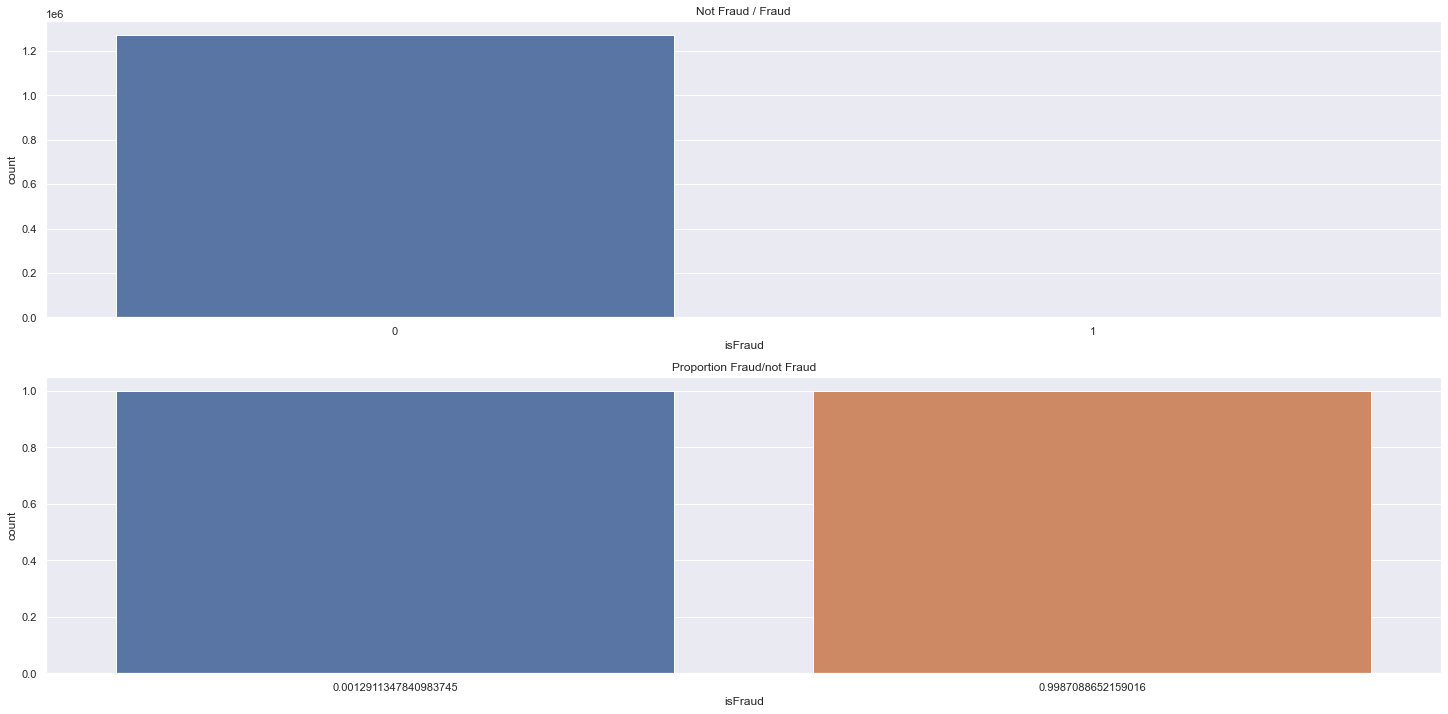

In [68]:
plt.subplot(2,1,1)
plt.title('Not Fraud / Fraud');
sns.countplot(df_eda['isFraud']);
plt.subplot(2,1,2)
plt.title('Proportion Fraud/not Fraud');
sns.countplot(df_eda['isFraud'].value_counts(normalize=True));

On the first graphic we can't see any behavior, because the number of fraud is a tiny proporction of all transactions.
On the second graphic we can see the proportion of fraud's(0,13%) and legitmic transactions(99,87%). 

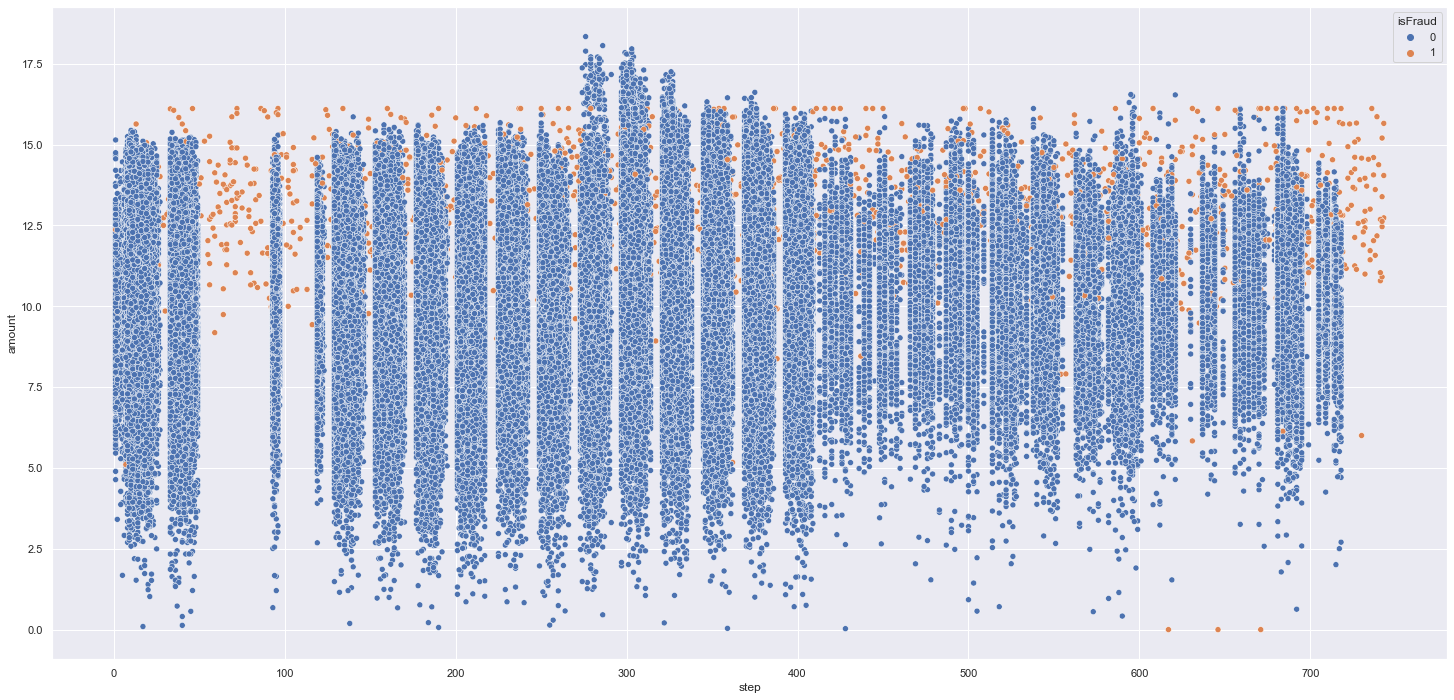

In [29]:
sns.scatterplot(x='step',y='amount',hue='isFraud',data=df_eda);

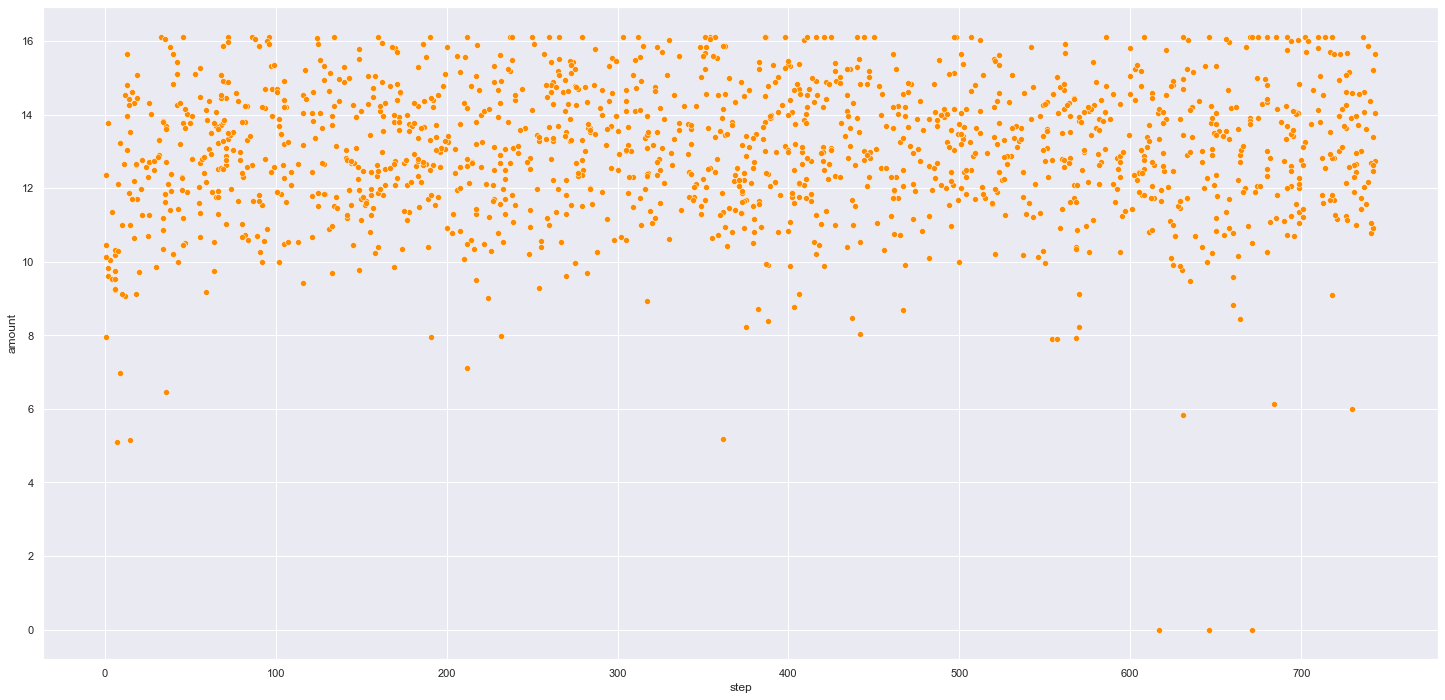

In [30]:
sns.scatterplot(x='step',y='amount',data=aux,color='darkorange');

Distributions of frauds by time and amount

### 3.1.2. Numerical Variables

In [84]:
numerical_cols = df_eda.select_dtypes(include = ['int64','float64','int32','int16','int8']).columns.tolist()

In [30]:
numerical_attributes.describe()

step        amount  oldbalanceOrg  newbalanceOrig  oldbalanceDest  newbalanceDest      isFraud  isFlaggedFraud
count 6362620.0000  6362620.0000   6362620.0000    6362620.0000    6362620.0000    6362620.0000 6362620.0000    6362620.0000
mean      243.3972   179861.9035    833883.1041     855113.6686    1100701.6665    1224996.3982       0.0013          0.0000
std       142.3320   603858.2315   2888242.6730    2924048.5030    3399180.1130    3674128.9421       0.0359          0.0016
min         1.0000        0.0000         0.0000          0.0000          0.0000          0.0000       0.0000          0.0000
25%       156.0000    13389.5700         0.0000          0.0000          0.0000          0.0000       0.0000          0.0000
50%       239.0000    74871.9400     14208.0000          0.0000     132705.6650     214661.4400       0.0000          0.0000
75%       335.0000   208721.4775    107315.1750     144258.4100     943036.7075    1111909.2500       0.0000          0.0000
max       743.0000 92445516.6400  59585040.3700   49585040.3700  356015889.3500  356179278.9200       1.0000          1.0000

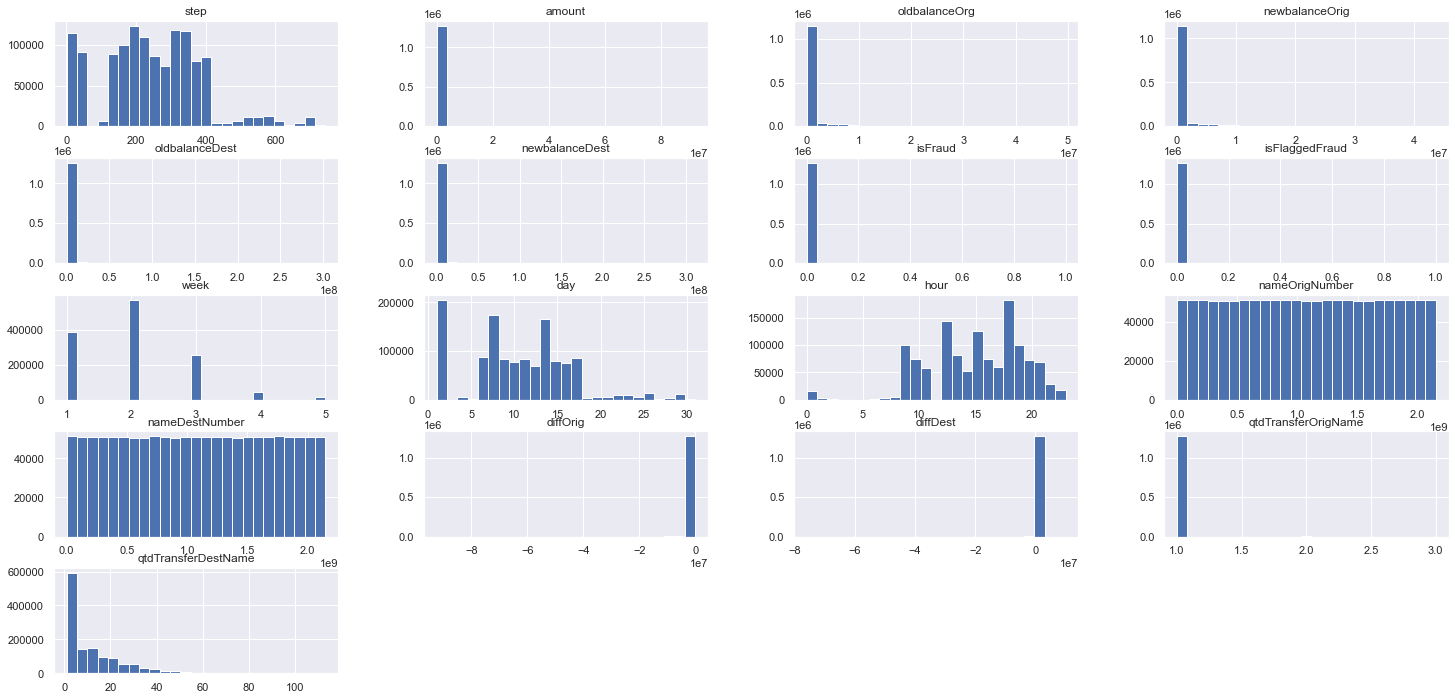

In [70]:
df_eda[numerical_cols].hist(bins=25);

We can't identify any behavior, because a proportion of frauds. Lets see each feature alone applied logarithm on values.

#### 3.1.2.1. Financial Data

##### Amount

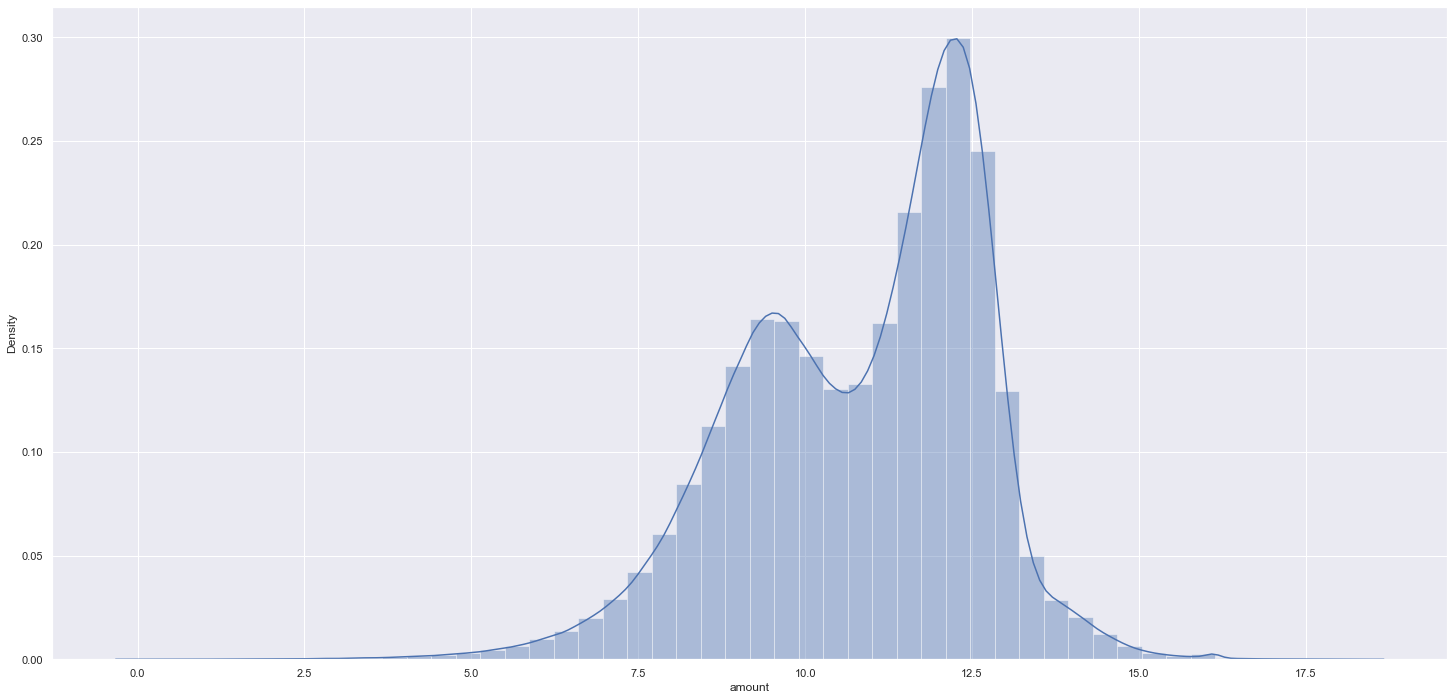

In [22]:
plt.title('Total Amount')
sns.distplot(df_eda['amount']);

##### Balance Orign

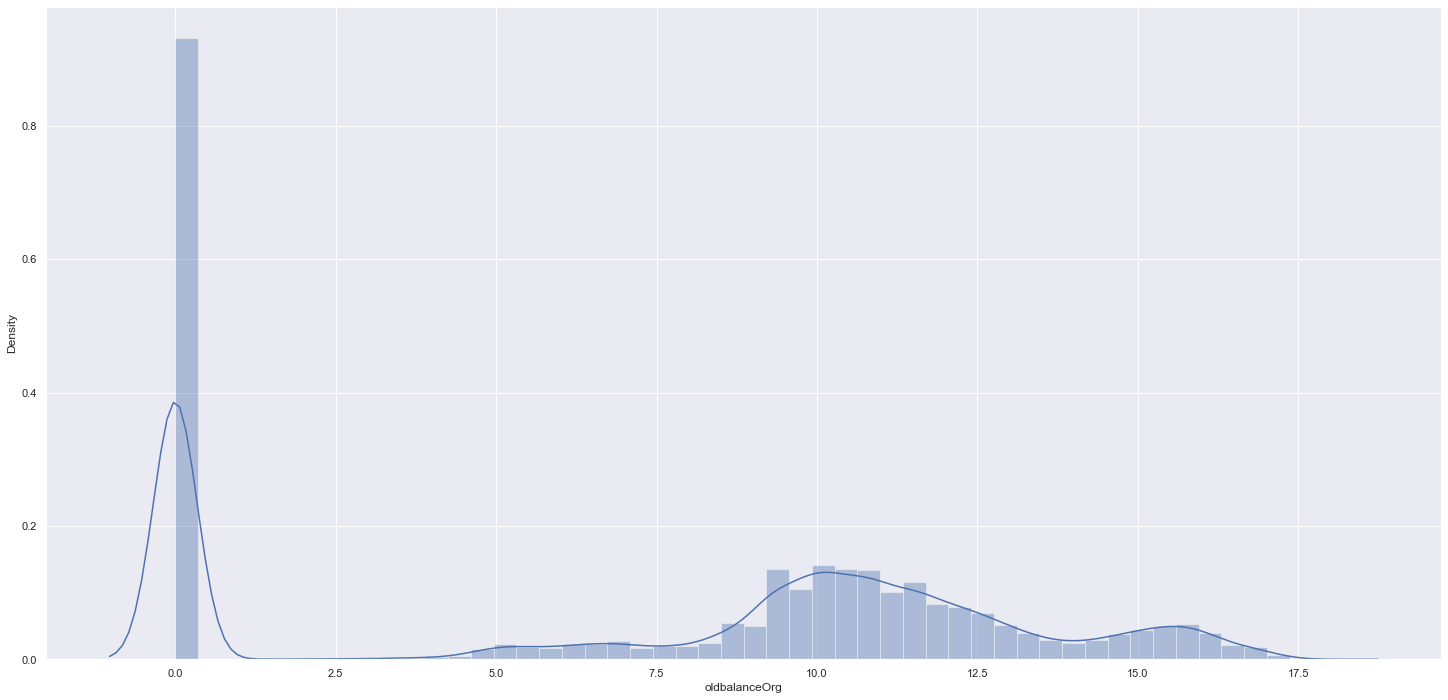

In [20]:
plt.title('Old Balance on Orign Name')
sns.distplot(df_eda['oldbalanceOrg']);

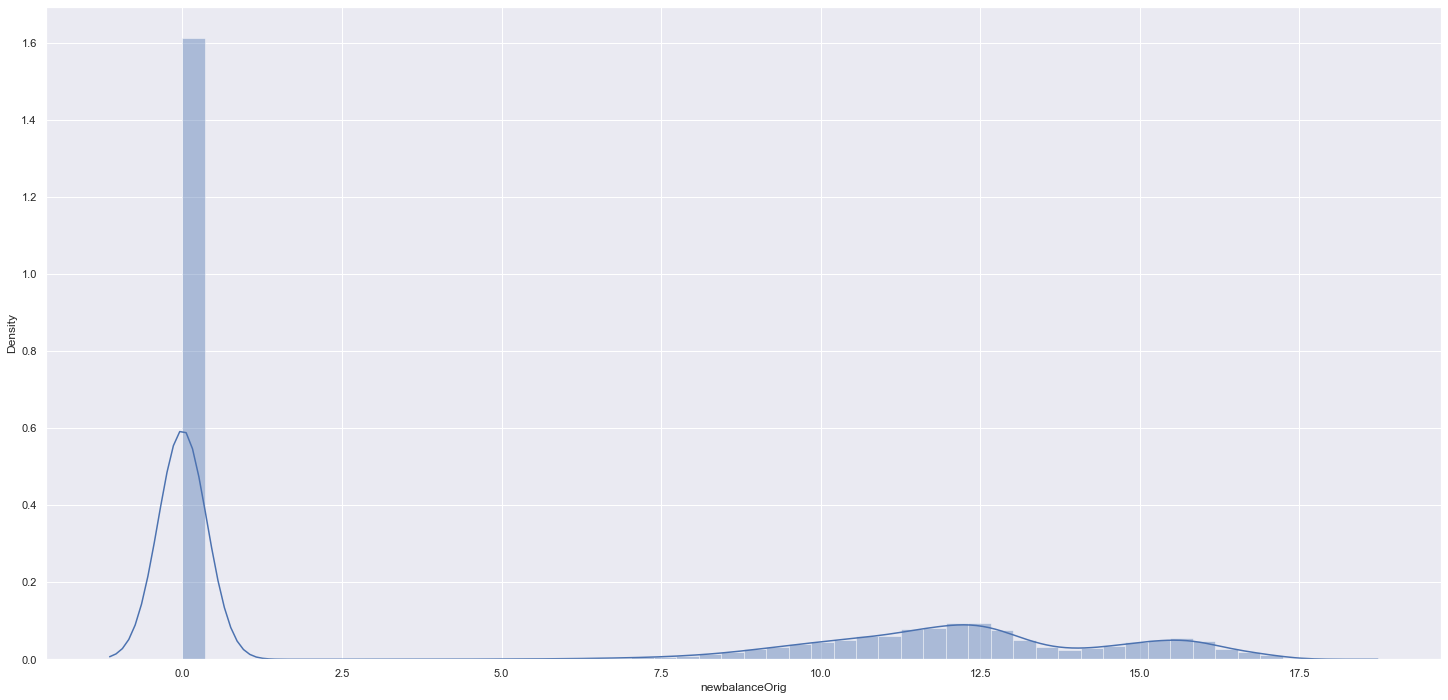

In [23]:
plt.title('New Balance on Orign Name')
sns.distplot(df_eda['newbalanceOrig']);

##### Balance Dest

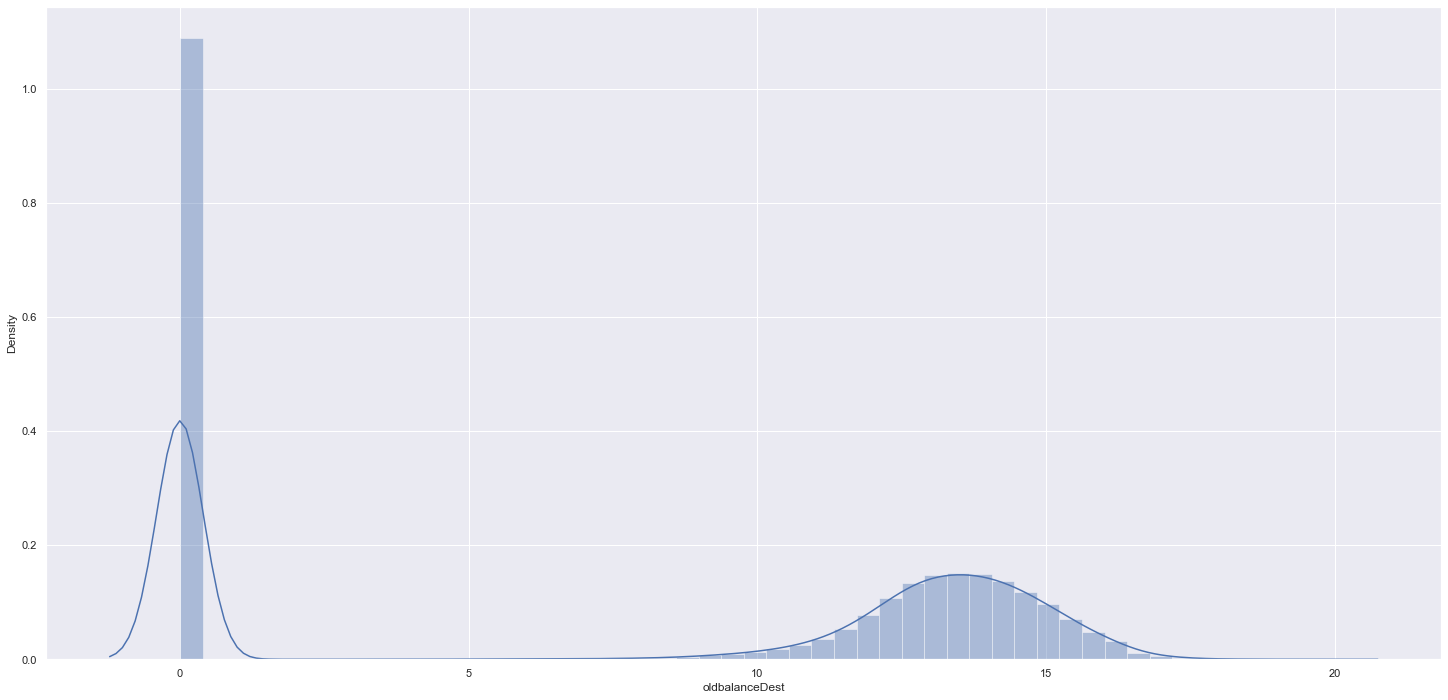

In [112]:
plt.title('Old Balance on destination Name')
sns.distplot(df_eda['oldbalanceDest']);

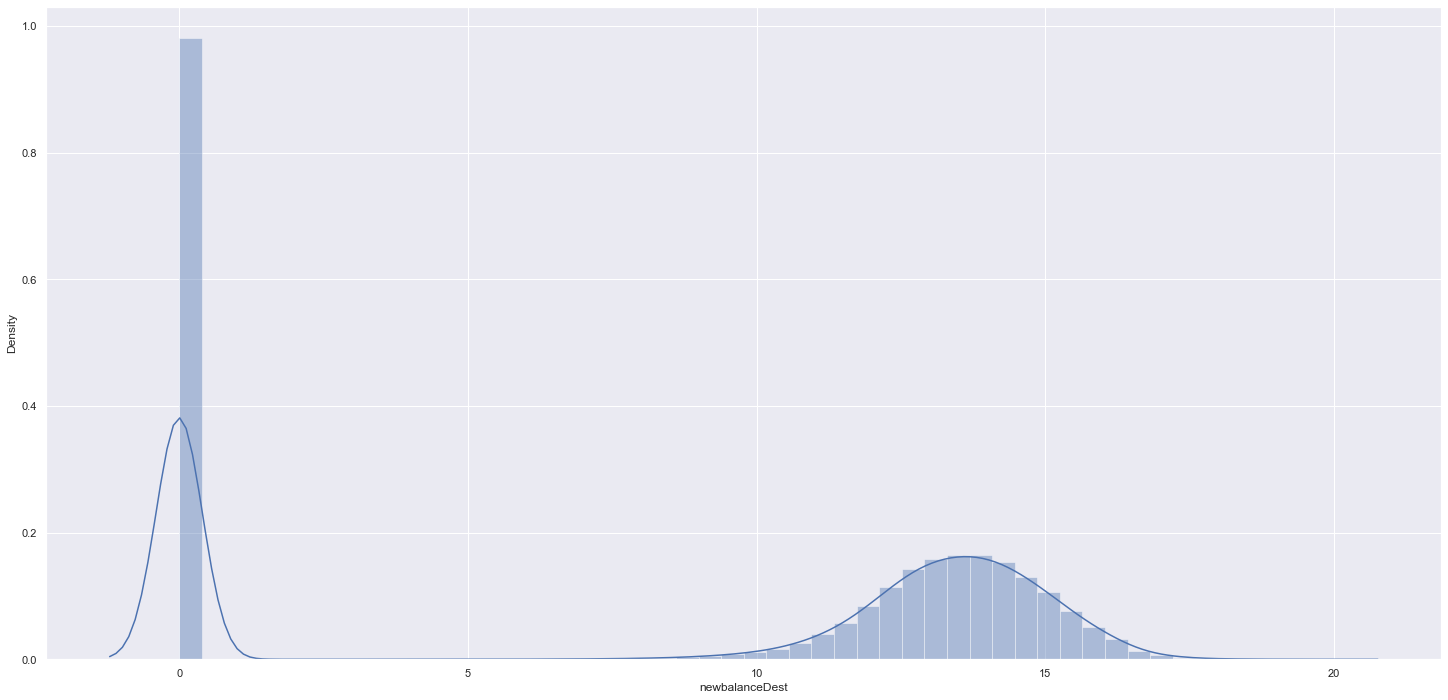

In [113]:
plt.title('New Balance on destination Name')
sns.distplot(df_eda['newbalanceDest']);

##### Delta Balance

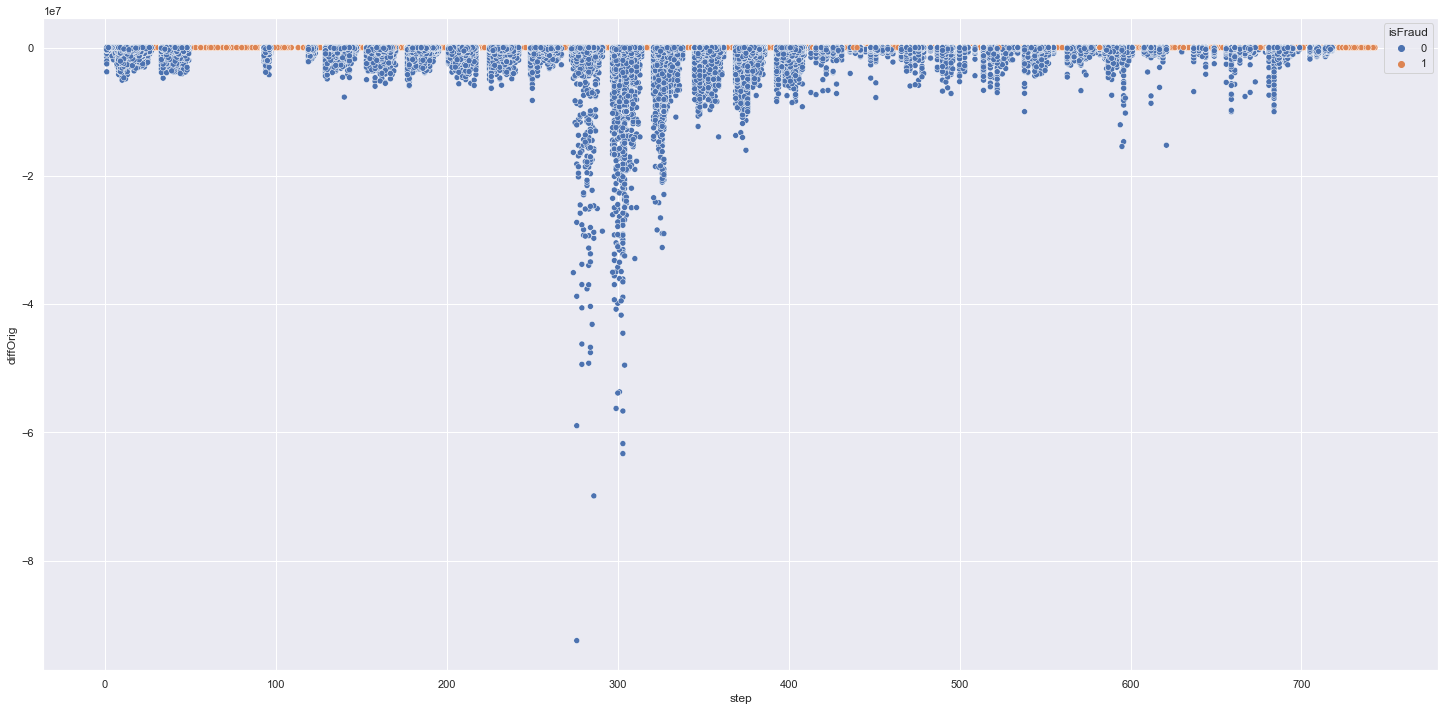

In [19]:
plt.title('Error between Balances x Amount from Orign Name')
sns.scatterplot(x='step',y='diffOrig',data=df_eda,hue='isFraud');

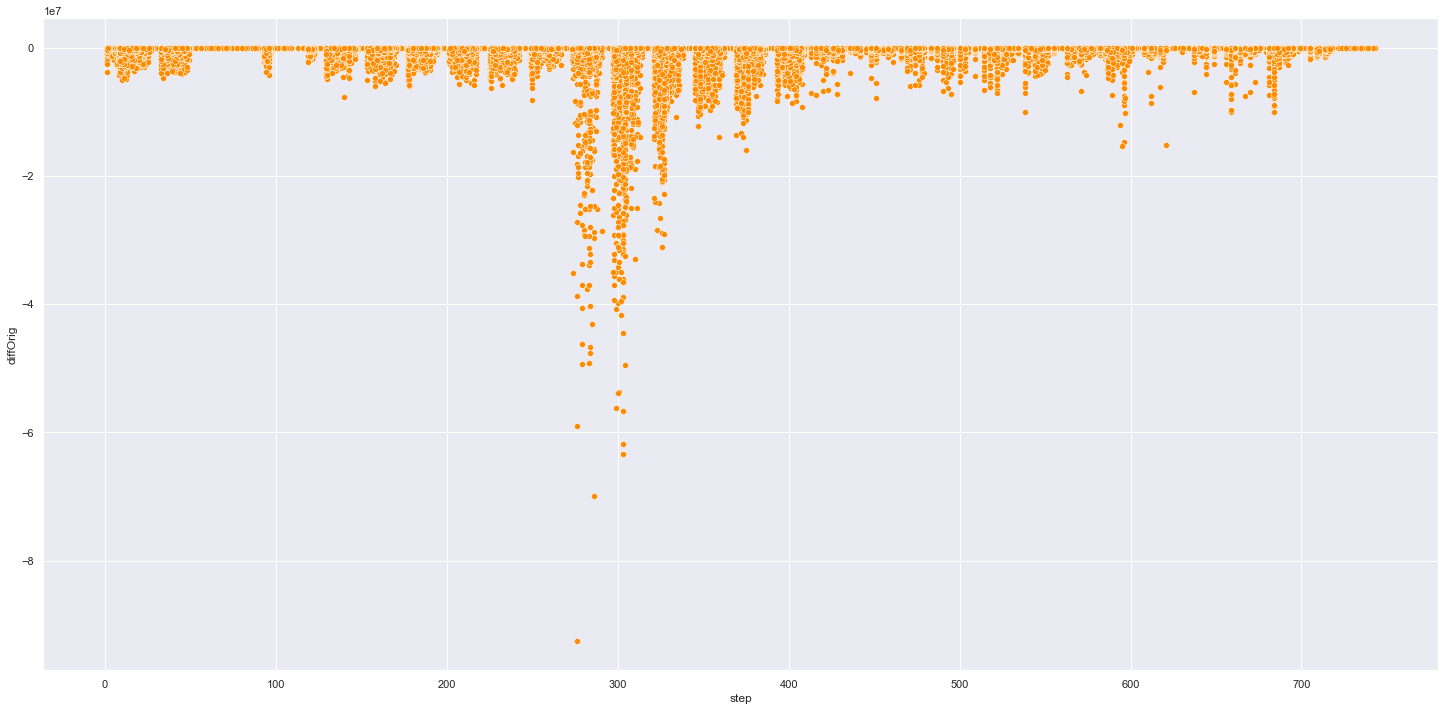

In [18]:
plt.title('Error between Balances x Amount from Orign Name on Frauds')
sns.scatterplot(x='step',y='diffOrig',data=df_eda,color='darkorange');

The most fraud transaction was negative balance on field diffOrign. The amount transfer was higher than orig balance.

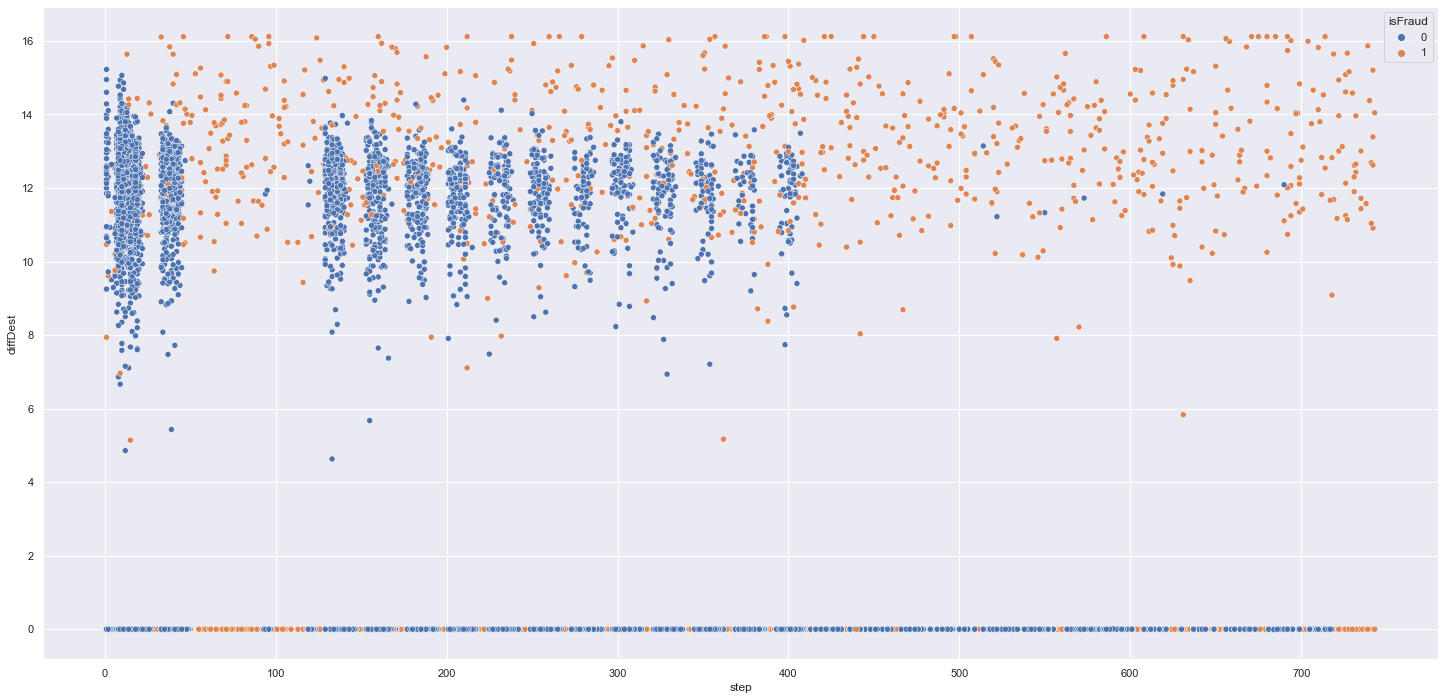

In [106]:
plt.title('Error between Balances x Amount from Destination Name')
sns.scatterplot(x='step',y='diffDest',data=df_eda,hue='isFraud');

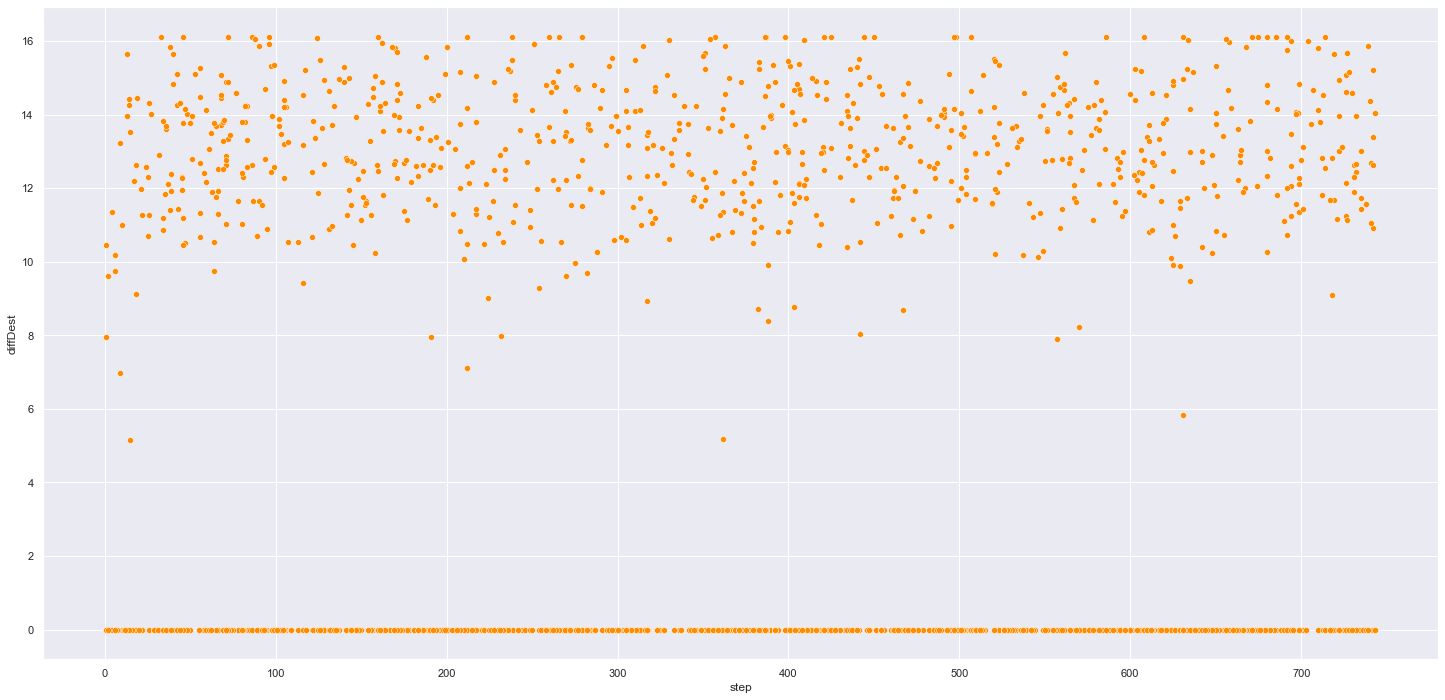

In [115]:
plt.title('Error between Balances x Amount from Destination Name on Frauds')
sns.scatterplot(x='step',y='diffDest',data=aux,color='darkorange');

The most fraud transaction was positive balance on field diffDest. The amount transfer no credit the account.

#### 3.1.2.2. Transfer

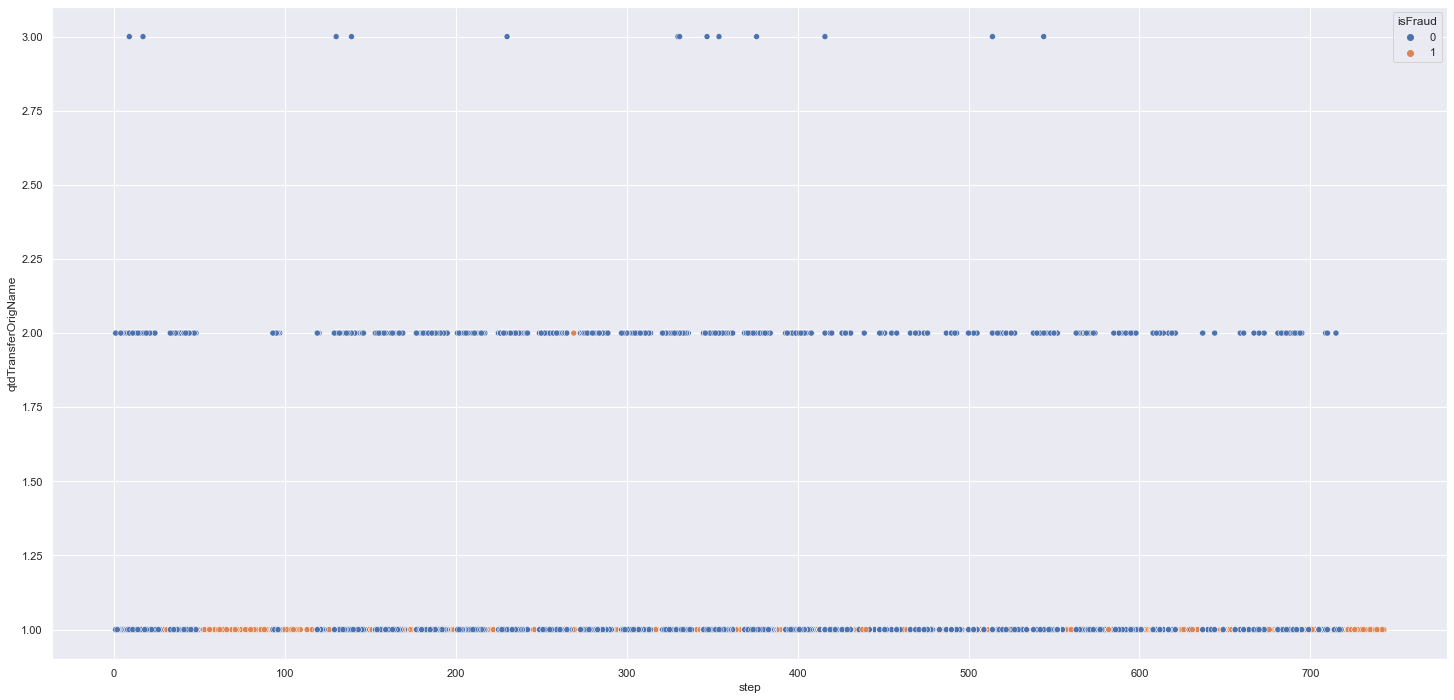

In [30]:
#plt.title('Total Quantity Transfer from Orign Name')
#sns.distplot(df_eda['qtdTransferOrigName']);
sns.scatterplot(x='step',y='qtdTransferOrigName',hue='isFraud',data=df_eda);

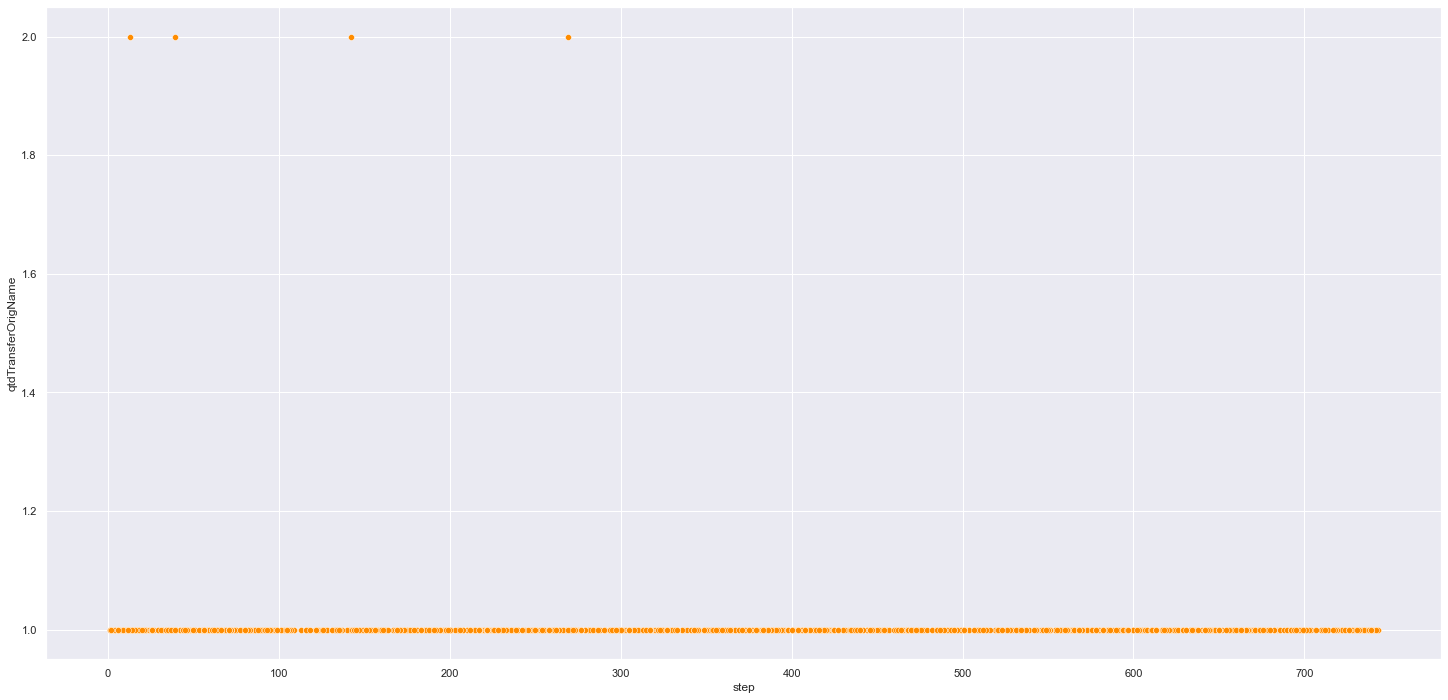

In [34]:
#plt.title('Total Quantity Transfer from Orign Name')
#sns.distplot(df_eda['qtdTransferOrigName']);
sns.scatterplot(x='step',y='qtdTransferOrigName',data=aux,color='darkorange');

The most frauds, have 1 transaction on account orig

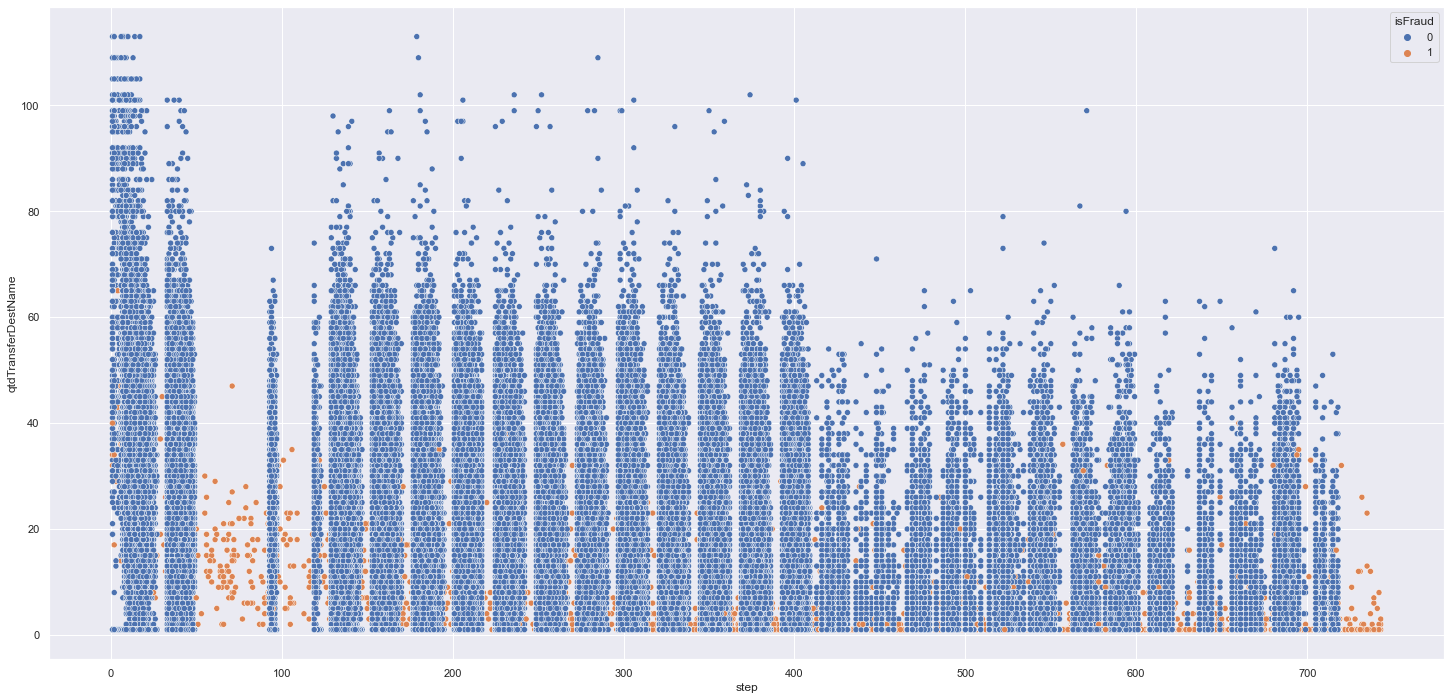

In [35]:
#plt.title('Total Quantity Transfer to Destination Name')
#sns.distplot(df_eda['qtdTransferDestName']);
sns.scatterplot(x='step',y='qtdTransferDestName',hue='isFraud',data=df_eda);

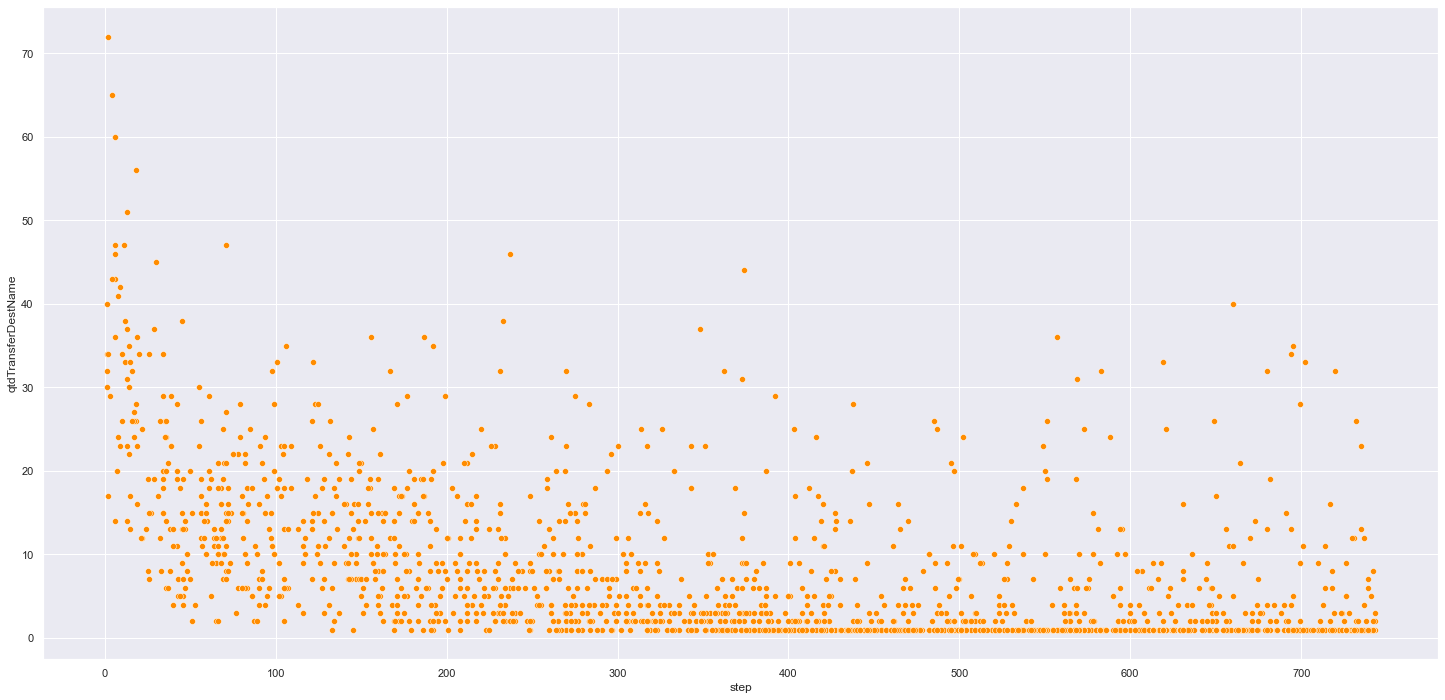

In [36]:
#plt.title('Total Quantity Transfer to Destination Name')
#sns.distplot(df_eda['qtdTransferDestName']);
sns.scatterplot(x='step',y='qtdTransferDestName',data=aux,color='darkorange');

The most frauds, have several transactions to account dest

#### 3.1.2.3. Temporal

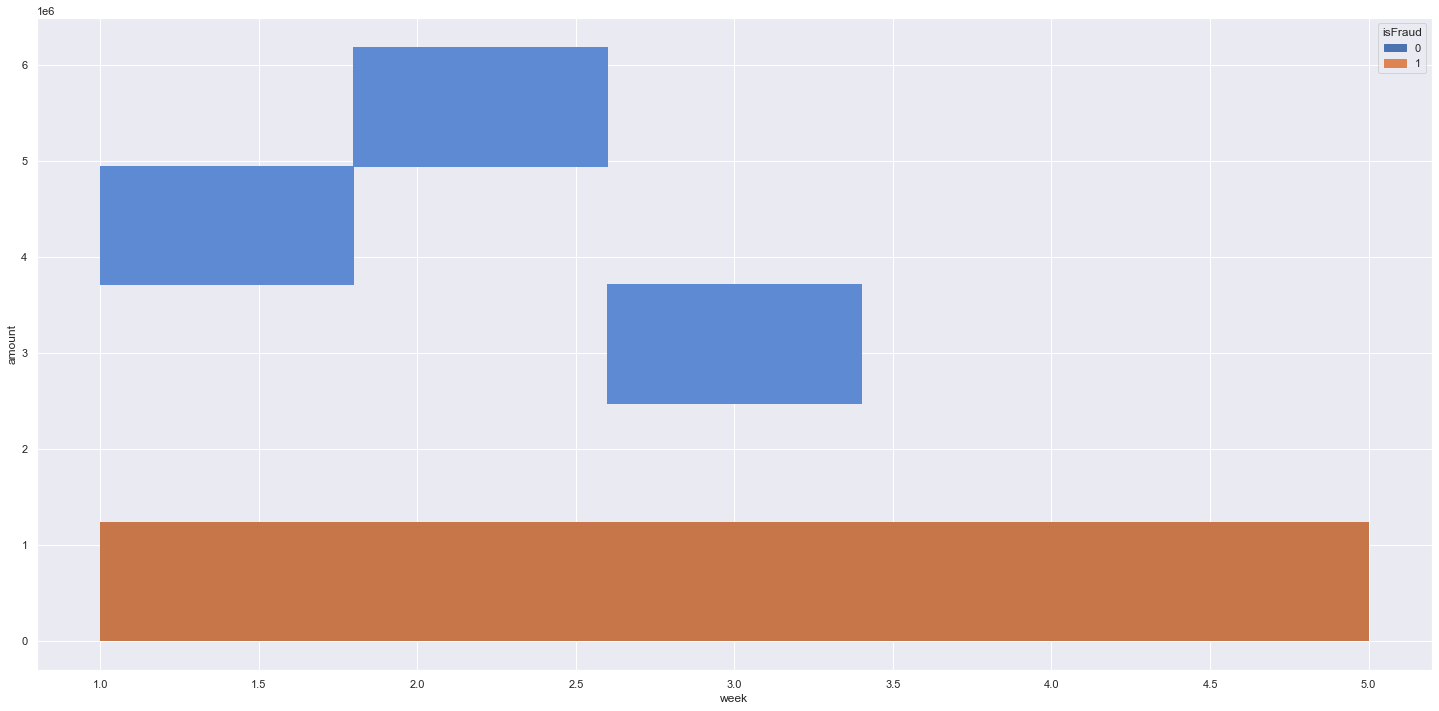

In [43]:
plt.title('Total Frauds by week')
aux=df_eda[['week','isFraud','amount']].groupby(['week','isFraud']).sum().reset_index()
sns.histplot(x='week',y='amount',hue='isFraud',data=aux);

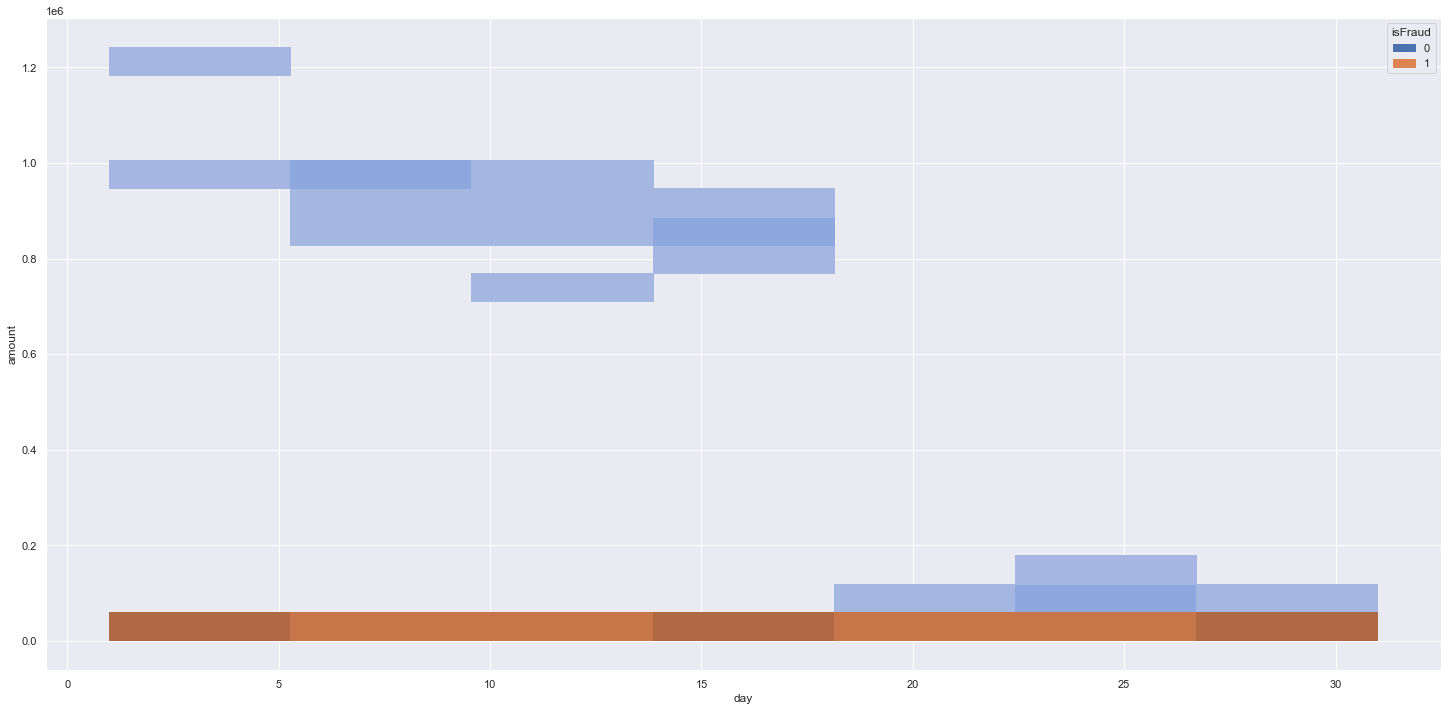

In [44]:
plt.title('Total Frauds by day')
aux=df_eda[['day','isFraud','amount']].groupby(['day','isFraud']).sum().reset_index()
sns.histplot(x='day',y='amount',hue='isFraud',data=aux);

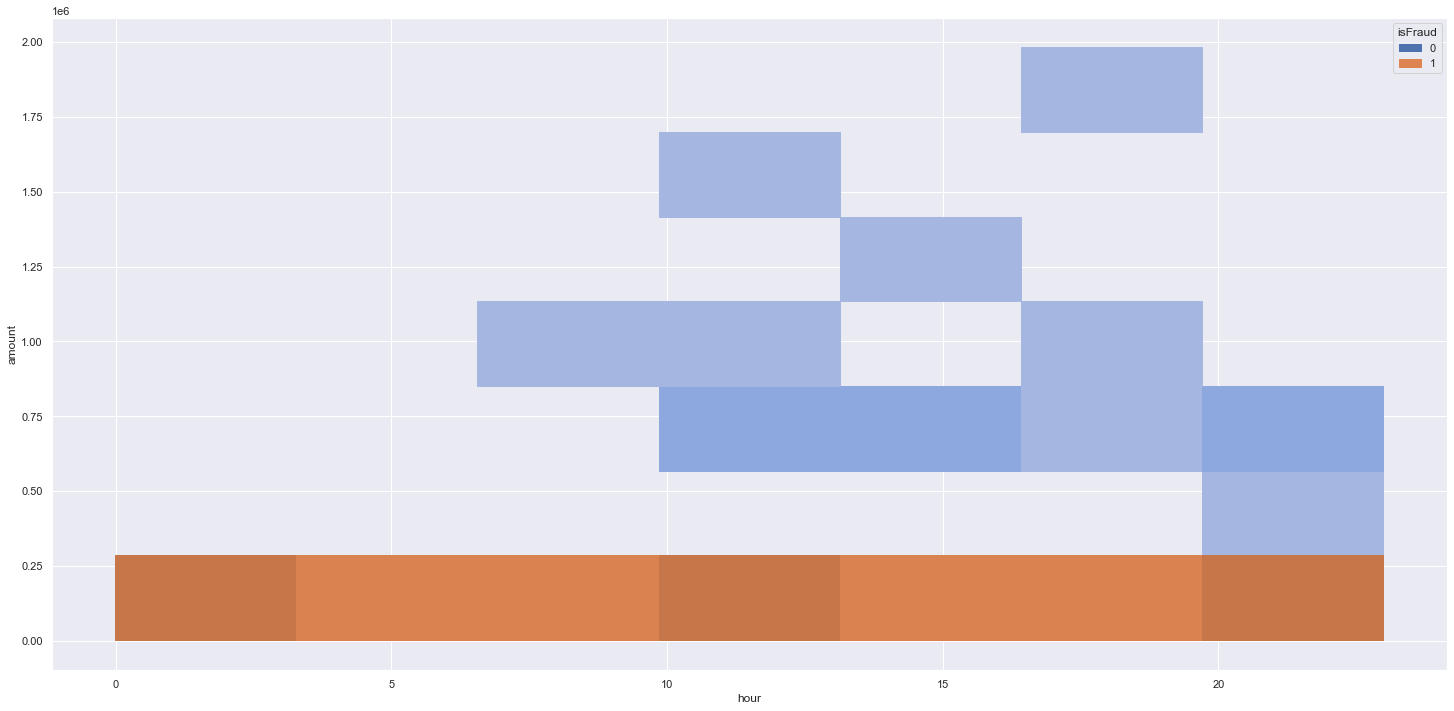

In [39]:
plt.title('Total Frauds by hour')
aux=df_eda[['hour','isFraud','amount']].groupby(['hour','isFraud']).sum().reset_index()
sns.histplot(x='hour',y='amount',hue='isFraud',data=aux);

Frauds was distributed in all week, day and hours of day.

### 3.1.3. Categorical Variables

In [34]:
categorical_cols = df_eda.select_dtypes(exclude = ['int64','float64','int32','int16','int8']).columns.tolist()

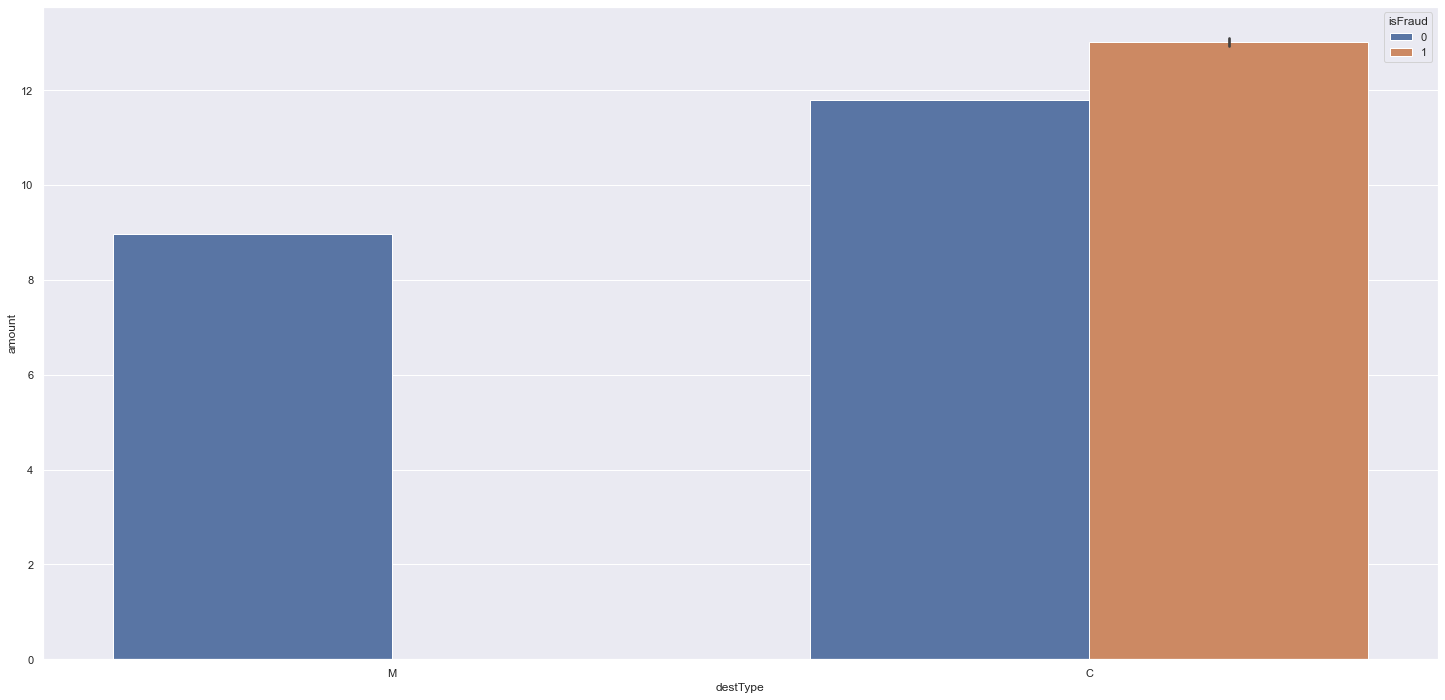

In [47]:
plt.title('Total Frauds by Destination Type')
sns.barplot(x='destType',y='amount',hue='isFraud',data=df_eda);

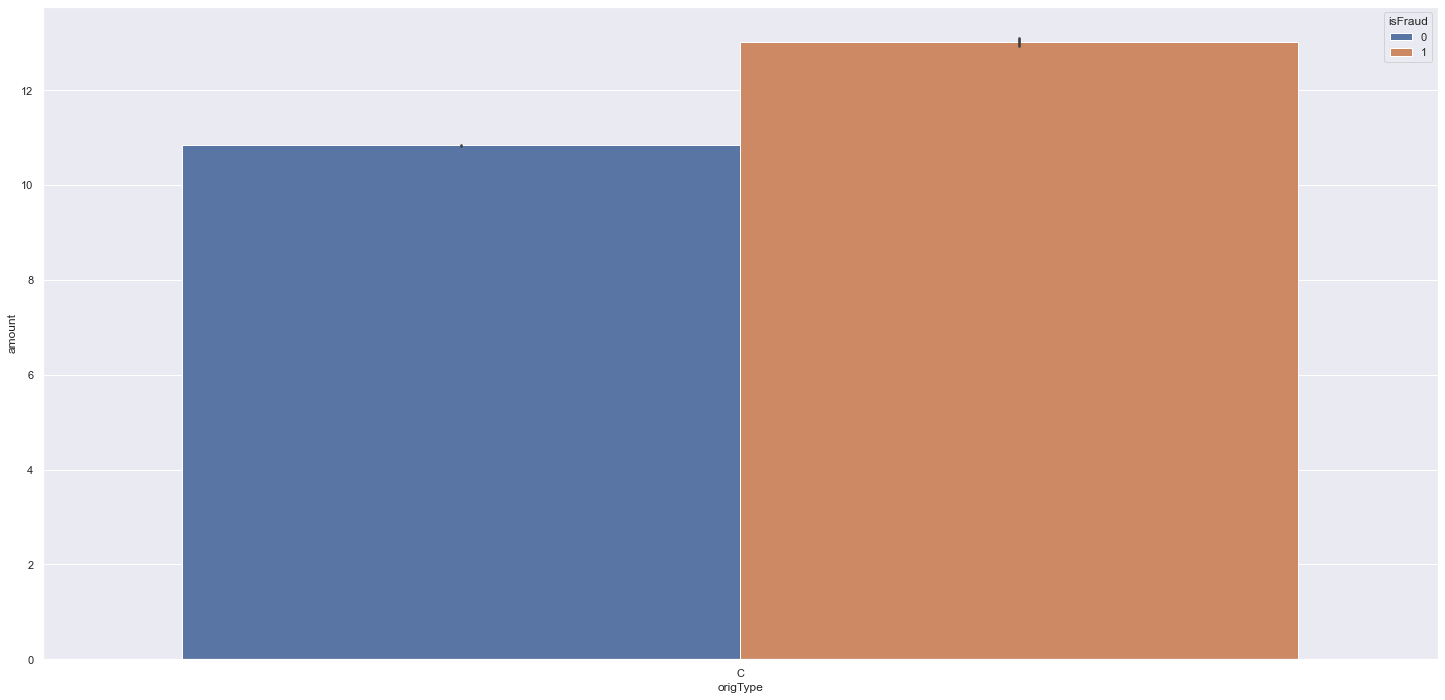

In [48]:
plt.title('Total Frauds by Orign Type')
sns.barplot(x='origType',y='amount',hue='isFraud',data=df_eda);

There is no Fraud transactions on Mercantis Type

<AxesSubplot:xlabel='type', ylabel='amount'>

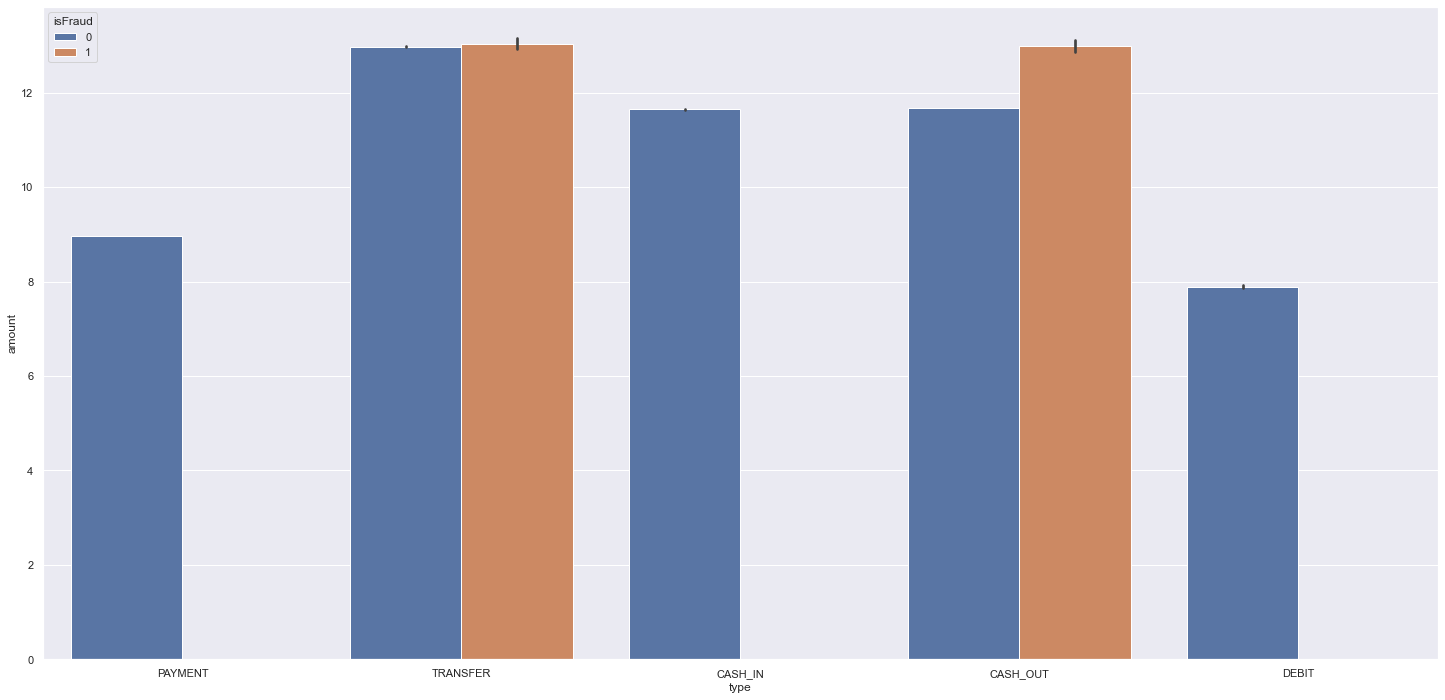

In [65]:
plt.title('Total Frauds by Type Transaction')
sns.barplot(x='type',y='amount',hue='isFraud',data=df_eda);

Only "Transfer" and "Cash out" types has Frauds

## 3.2. Bivariable

### H1 - Most Frauds occurs between days 5 and 15
**False** most fraud occurs after the 15th

In [66]:
h1=aux['day'].apply(lambda x: 'm5' if x<5 else '5e15' if x>5 and x<=15 else 'M15').reset_index()

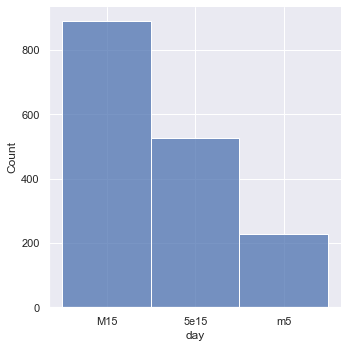

In [77]:
sns.displot(h1['day']);

### H2 - Most Frauds occurs on afternoon
**True** On afternoon and dawn occours the most quantity of frauds

In [74]:
h2=aux['hour'].apply(lambda x: 'afternoon' if x>=12 and x<=18 else 'dawn' if x>=0 and x<=6 else 'morning' if x>=7 and x<=12 else 'night').T.reset_index()

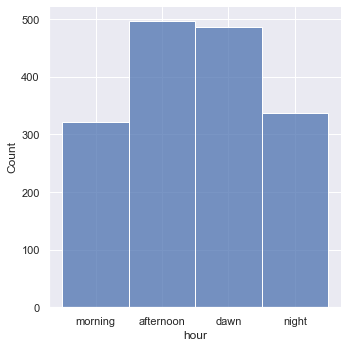

In [78]:
sns.displot(h2['hour']);

### H3 - Most Frauds occurs on month's second week

**False** Between week 1 and 4 the quantity of fraud was close

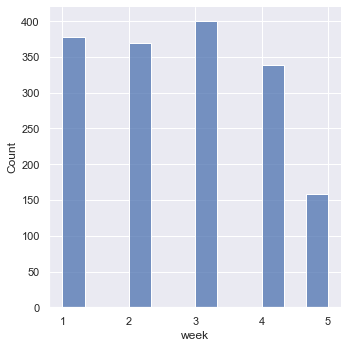

In [80]:
sns.displot(aux['week']);

### H4 - Most Frauds occurs on Transfer Transactions
**False** The quantity of fraud was close in all Type Transactions

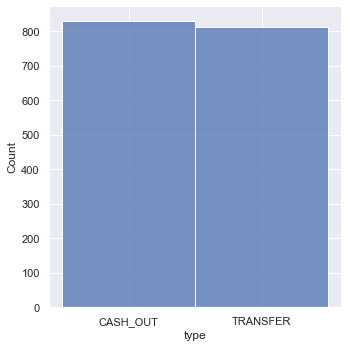

In [82]:
sns.displot(aux['type']);

## 3.3. Multivariable

In [ ]:
#sns.countplot(isFraud['amount'])

### 3.3.1. Numericals

<AxesSubplot:>

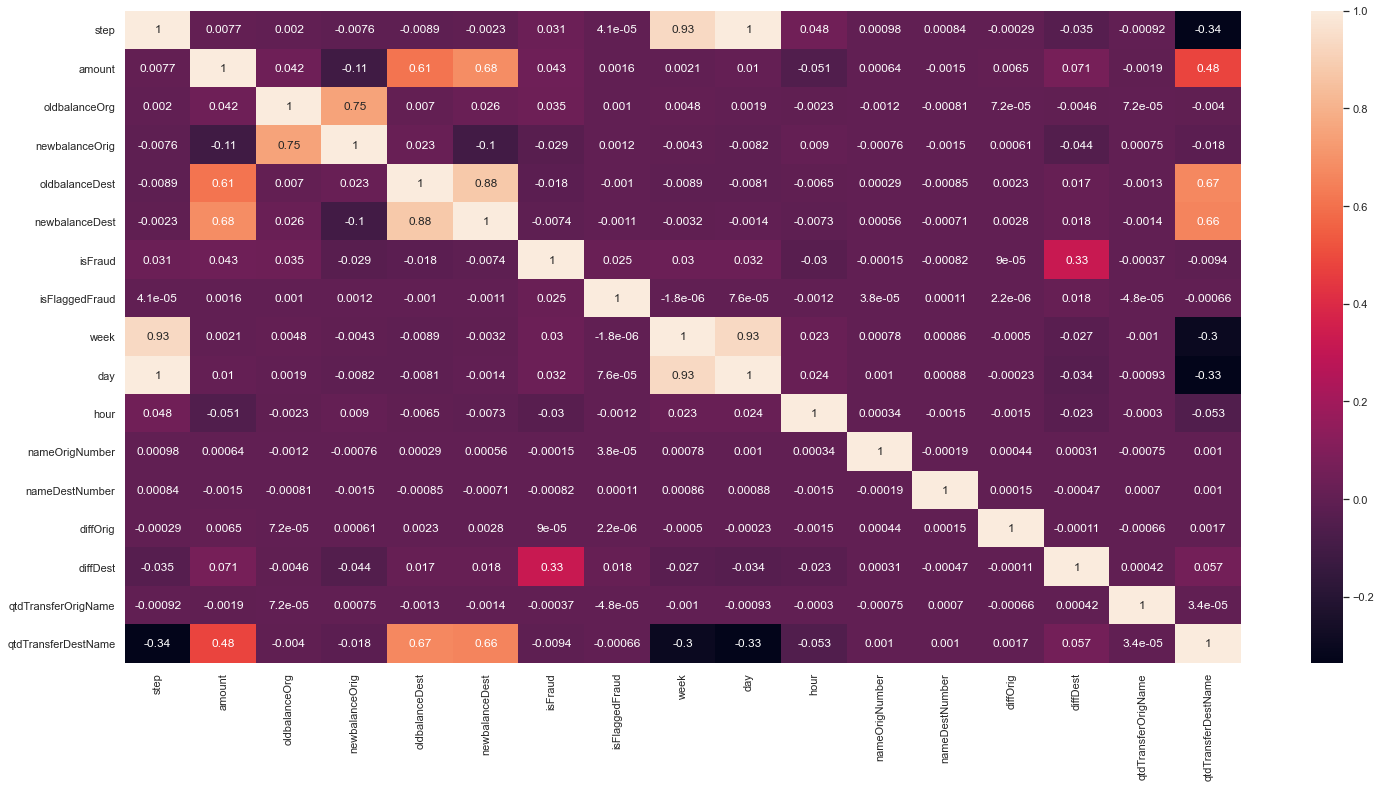

In [85]:
correlation = df_eda[numerical_cols].corr(method='pearson')
sns.heatmap(correlation,annot=True)

# 4.0. Data preparation

In [13]:
df_dp=df_fe.copy()

## 4.1. Reescaling

In [14]:
mms = pp.MinMaxScaler()
rrs = pp.RobustScaler()

In [15]:
df_dp['step']=mms.fit_transform(df_dp[['step']])
df_dp['qtdTransferOrigName']=mms.fit_transform(df_dp[['qtdTransferOrigName']])
df_dp['qtdTransferDestName']=mms.fit_transform(df_dp[['qtdTransferDestName']])
df_dp['oldbalanceOrg']=rrs.fit_transform(df_dp[['oldbalanceOrg']])
df_dp['newbalanceOrig']=rrs.fit_transform(df_dp[['newbalanceOrig']])
df_dp['oldbalanceDest']=rrs.fit_transform(df_dp[['oldbalanceDest']])
df_dp['newbalanceDest']=rrs.fit_transform(df_dp[['newbalanceDest']])
df_dp['week']=mms.fit_transform(df_dp[['week']])
df_dp['day']=mms.fit_transform(df_dp[['day']])
df_dp['nameOrigNumber']=mms.fit_transform(df_dp[['nameOrigNumber']])
df_dp['nameDestNumber']=mms.fit_transform(df_dp[['nameDestNumber']])
df_dp['diffOrig']=rrs.fit_transform(df_dp[['diffOrig']])
df_dp['diffDest']=rrs.fit_transform(df_dp[['diffDest']])

## 4.2. Encoding

In [16]:
df_dp= pd.get_dummies(df_dp,prefix=['type'],columns=['type'])
df_dp= pd.get_dummies(df_dp,prefix=['origType'],columns=['origType'])
df_dp= pd.get_dummies(df_dp,prefix=['destType'],columns=['destType'])

## 4.3. Nature Transform

In [17]:
df_dp['hour_sin']=df_dp['hour'].apply(lambda x: np.sin(x*(2*np.pi/24)))
df_dp['hour_cos']=df_dp['hour'].apply(lambda x: np.cos(x*(2*np.pi/24)))

In [36]:
df_dp.head()

step   amount     nameOrig  oldbalanceOrg  newbalanceOrig     nameDest  oldbalanceDest  newbalanceDest  isFraud  isFlaggedFraud    week     day  hour  nameOrigNumber  nameDestNumber  diffOrig  diffDest  type_CASH_IN  type_CASH_OUT  type_DEBIT  type_PAYMENT  type_TRANSFER  origType_C  destType_C  destType_M  hour_sin  hour_cos
0 0.00000 -0.33293  C1231006815        1.45299         1.11118  M1979787155        -0.14072        -0.19306        0               0 0.00000 0.00000     1         0.57323         0.92191   0.27840   0.00000             0              0           0             1              0           1           0           1   0.25882   0.96593
1 0.00000 -0.37376  C1666544295        0.06561         0.13437  M2044282225        -0.14072        -0.19306        0               0 0.00000 0.00000     1         0.77605         0.95194   0.27840   0.00000             0              0           0             1              0           1           0           1   0.25882   0.96593
2 0.00000 -0.38238  C1305486145       -0.13071         0.00000   C553264065        -0.14072        -0.19306        1               0 0.00000 0.00000     1         0.60791         0.25763   0.27840   0.00000             0              0           0             0              1           1           1           0   0.25882   0.96593
3 0.00000 -0.38238   C840083671       -0.13071         0.00000    C38997010        -0.11826        -0.19306        1               0 0.00000 0.00000     1         0.39119         0.01816   0.27840   0.00000             0              1           0             0              0           1           1           0   0.25882   0.96593
4 0.00000 -0.32357  C2048537720        0.25482         0.20717  M1230701703        -0.14072        -0.19306        0               0 0.00000 0.00000     1         0.95392         0.57309   0.27840   0.00000             0              0           0             1              0           1           0           1   0.25882   0.96593

# 5.0. Feature Selection

In [18]:
cols_drop=['nameOrig','nameDest','step' #original Dates derivated on Feature Engieeniering
          ,'hour' #date transform on Data Preparation
          ,'nameOrigNumber','nameDestNumber' #data not Relevant to model
          ]
df_fs=df_dp.drop(cols_drop,axis=1)

In [19]:
x = df_fs.drop('isFraud',axis=1)
y = df_fs['isFraud']


split = ms.StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=77)
for train_index, test_index in split.split(x,y):
    x_train,x_test = x.loc[train_index],x.loc[test_index]
    y_train,y_test = y.loc[train_index],y.loc[test_index]

In [20]:
x_train, x_val,y_train,y_val = ms.train_test_split(x_train,y_train, test_size=0.2)

In [51]:
y_val.head()

4514333    0
975860     0
3295972    0
6309406    0
818720     0
Name: isFraud, dtype: int8

## 5.1 Feature Importance

In [25]:
importance

array([0.00807986, 0.06193096, 0.39483578, 0.01737475, 0.0189099 ,
       0.        , 0.00010103, 0.02439384, 0.24396354, 0.18720683,
       0.        , 0.00080434, 0.        , 0.02628115, 0.        ,
       0.00023595, 0.0116611 , 0.        , 0.00043762, 0.00014062,
       0.00276316, 0.00087957])

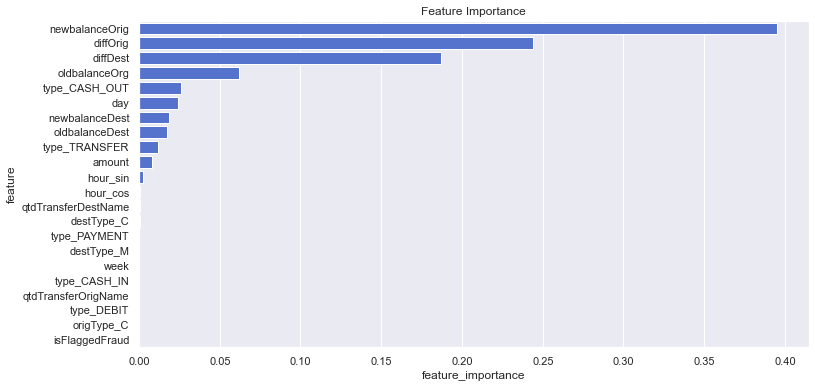

In [28]:
rf = RandomForestRegressor()
# fit the model
rf.fit(x_val, y_val)
# get importance
importance = rf.feature_importances_
# summarize feature importance
for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
feat_imp = pd.DataFrame({'feature': x_val.columns,
                        'feature_importance': importance})\
                        .sort_values('feature_importance', ascending=False)\
                        .reset_index(drop=True)
plt.subplots(figsize=(12,6))
sns.barplot(x='feature_importance', y='feature', data=feat_imp, orient='h', color='royalblue')\
    .set_title('Feature Importance');

## 5.2. Boruta

In [ ]:
#definindo dataset de treino e teste para o Boruta
x_train_b = x_train.values
y_train_b = y_train.values.ravel()

#definição da Random Forest
#n_jobs = numero do cores para utilização
rf=RandomForestClassifier( n_jobs=-1)

#definição do Boruta

#rf = algoritimo utilizado no Boruta, neste caso random forest
#estimators = numero de arvores para ramificação
#verbose = enxergar os prints do que ele está fazendo
#random_state= numero da aleatoriedade a ser aplicado em todas as features
#comentado linha abaixo para nao rodar novamente
boruta = BorutaPy(rf,n_estimators='auto',verbose=2,random_state=77).fit(x_train_b,y_train_b)

In [ ]:
#comentado para não fazer o algoritimo do boruta#
cols_selected = boruta.support_.tolist()

#colunas selecionadas
x_train_fs=x_train
cols_selected_boruta = x_train_fs.iloc[:,cols_selected].columns.to_list()

#colunas não selecionadas
cols_not_selected_boruta = list(np.setdiff1d(x_train_fs.columns,cols_selected_boruta))
cols_selected_boruta

In [21]:
cols_selected_boruta=['amount',
 'oldbalanceOrg',
 'newbalanceOrig',
 'oldbalanceDest',
 'newbalanceDest',
 'diffOrig',
 'diffDest',
 'day',
 'hour_sin',
 'hour_cos',
 'type_CASH_OUT',
 'type_TRANSFER',
 'qtdTransferOrigName',
 'qtdTransferDestName']

# 6.0. Machine Learning Models

In [22]:
x_train=x_train[cols_selected_boruta]
x_val=x_val[cols_selected_boruta]
x_test=x_test[cols_selected_boruta]

In [23]:
model_performance=pd.DataFrame()

## 6.1. Baseline Model

In [24]:
isFraud_list = df_fs['isFraud'].drop_duplicates().sort_values().tolist()
isFraud_weights = df_fs['isFraud'].value_counts(normalize=True).sort_index().tolist()

k_num = y_val.shape[0]

yhat_random = rd.choices(population=isFraud_list,k=k_num,weights=isFraud_weights)

Accuracy: 0.9973723502485217
Balanced Accuracy: 0.5004560290504868
Kappa Score: 0.0009225898633058449
Precision Score: 0.0022123893805309734
Recall Score: 0.0022123893805309734
F1 Score: 0.0022379709063782166
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1016664
           1       0.00      0.00      0.00      1356

    accuracy                           1.00   1018020
   macro avg       0.50      0.50      0.50   1018020
weighted avg       1.00      1.00      1.00   1018020



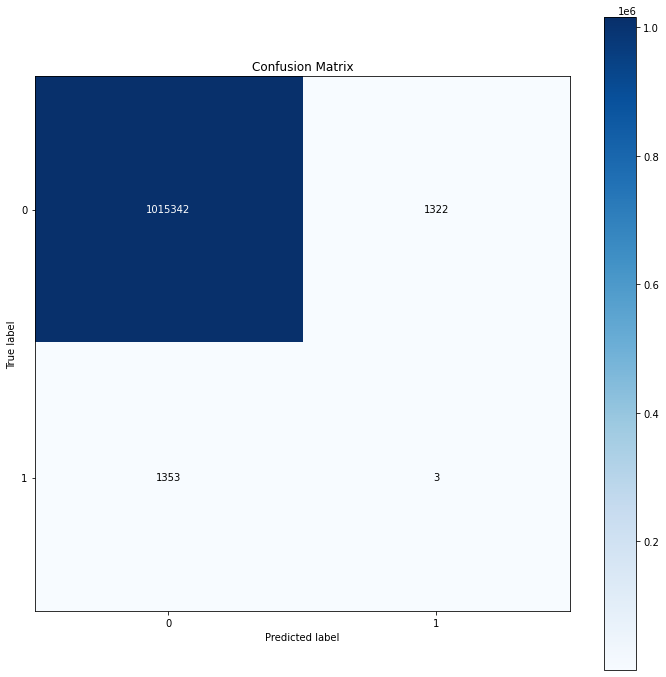

In [25]:
model_performance = model_performance.append(model_metrics('Random',y_val,yhat_random))

## 6.2. Ridge Classifier

In [26]:
model_ridge = linear_model.RidgeClassifier()
model_ridge.fit(x_train,y_train)

yhat_ridge = model_ridge.predict(x_val)


Accuracy: 0.998806506748394
Balanced Accuracy: 0.5519911504424779
Kappa Score: 0.18817305204288004
Precision Score: 0.10398230088495575
Recall Score: 0.10398230088495575
F1 Score: 0.188376753507014
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1016664
           1       1.00      0.10      0.19      1356

    accuracy                           1.00   1018020
   macro avg       1.00      0.55      0.59   1018020
weighted avg       1.00      1.00      1.00   1018020



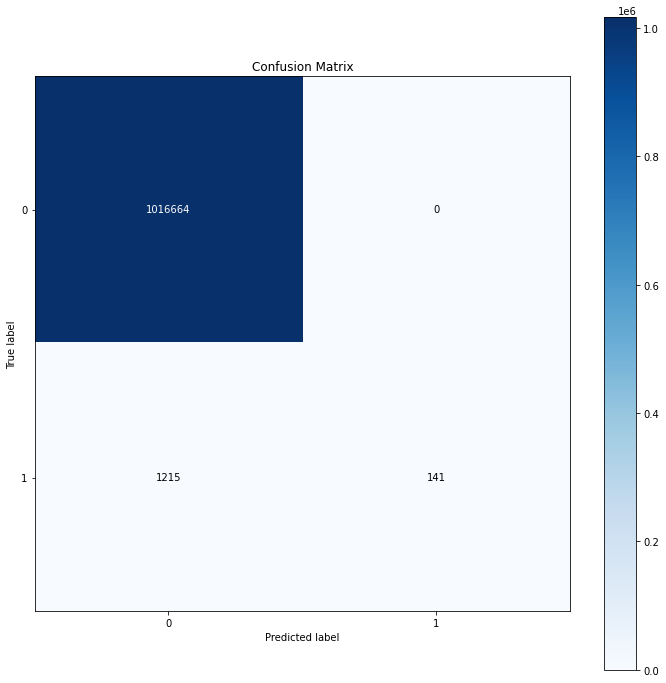

In [27]:
model_performance = model_performance.append(model_metrics('Ridge',y_val,yhat_ridge))

## 6.3. XGBoost Classifier 1

In [28]:
model_xgb =  xgb.XGBClassifier(objective='reg:squarederror',#funçao objetiva
                             n_estimators=100,#
                             eta=0.01,#quantas vezes ele passa pra aprender
                             max_depth=10,#maxima de ramificacao
                             subsample=0.7,#percentual de feature para amostragem
                             colsample_bytree=0.9).fit(x_train,y_train)

yhat_xgb=model_xgb.predict(x_val)


Accuracy: 0.9999931239071924
Balanced Accuracy: 0.9977871188149003
Kappa Score: 0.997410668950861
Precision Score: 0.995575221238938
Recall Score: 0.995575221238938
F1 Score: 0.9974141115626154
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1016664
           1       1.00      1.00      1.00      1356

    accuracy                           1.00   1018020
   macro avg       1.00      1.00      1.00   1018020
weighted avg       1.00      1.00      1.00   1018020



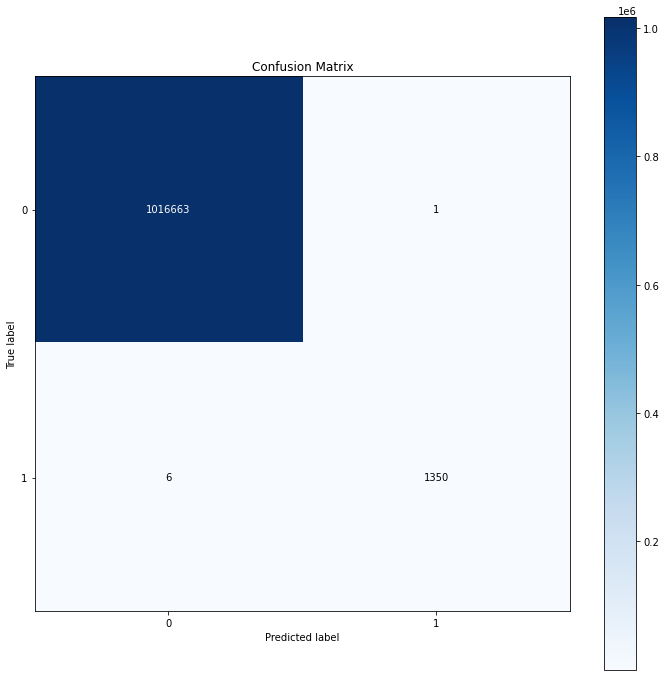

In [29]:
model_performance = model_performance.append(model_metrics('XGBoost',y_val,yhat_xgb))

## 6.3. XGBoost Classifier 2

In [30]:
model_xgb =  xgb.XGBClassifier(scale_pos_weight=99).fit(x_train,y_train)

yhat_xgb=model_xgb.predict(x_val)

[18:41:48] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


Accuracy: 0.9999882124123298
Balanced Accuracy: 0.997784659792057
Kappa Score: 0.995569319584114
Precision Score: 0.995575221238938
Recall Score: 0.995575221238938
F1 Score: 0.995575221238938
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1016664
           1       1.00      1.00      1.00      1356

    accuracy                           1.00   1018020
   macro avg       1.00      1.00      1.00   1018020
weighted avg       1.00      1.00      1.00   1018020



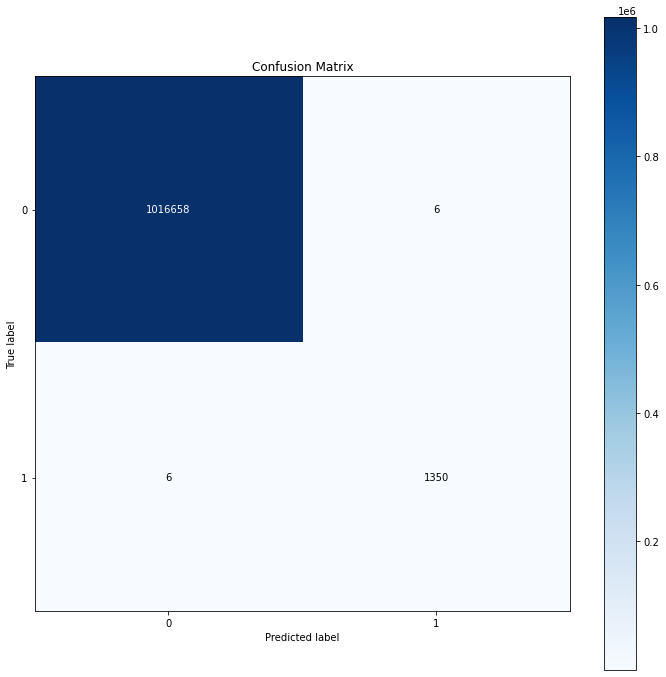

In [31]:
model_performance = model_performance.append(model_metrics('XGBoost 2',y_val,yhat_xgb))

## 6.4. Random Forest

In [32]:
model_rf =  RandomForestClassifier(n_estimators=100,
                                   random_state=77).fit(x_train,y_train)

yhat_rf=model_rf.predict(x_val)

Accuracy: 0.9999941062061649
Balanced Accuracy: 0.997787610619469
Kappa Score: 0.9977797542956003
Precision Score: 0.995575221238938
Recall Score: 0.995575221238938
F1 Score: 0.9977827050997783
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1016664
           1       1.00      1.00      1.00      1356

    accuracy                           1.00   1018020
   macro avg       1.00      1.00      1.00   1018020
weighted avg       1.00      1.00      1.00   1018020



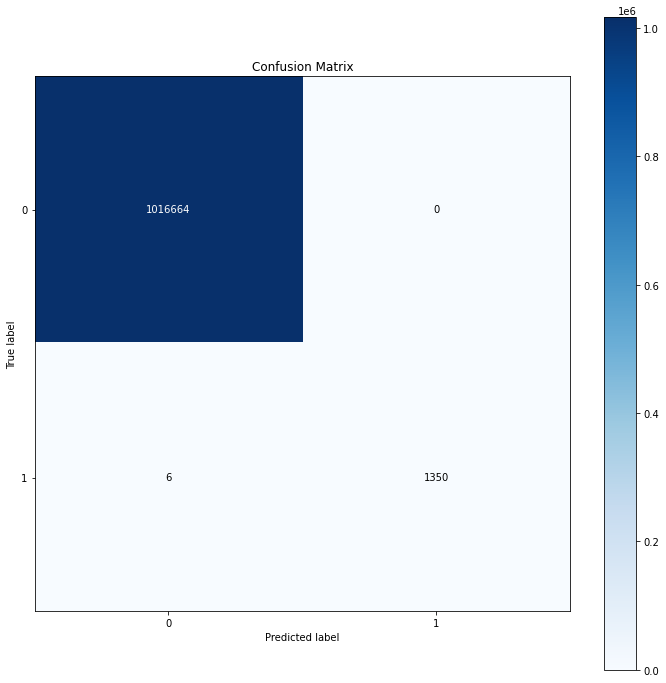

In [33]:
model_performance = model_performance.append(model_metrics('Random Forest',y_val,yhat_rf))

# 7.0. Models Performance

In [34]:
model_performance

Index          Model Accuracy Balanced Accuracy Kappa Score  \
0      0         Random   0.9974            0.5005      0.0009   
0      0          Ridge   0.9988            0.5520      0.1882   
0      0        XGBoost   1.0000            0.9978      0.9974   
0      0      XGBoost 2   1.0000            0.9978      0.9956   
0      0  Random Forest   1.0000            0.9978      0.9978   

  Precision Score Recall Score F1 Score  
0          0.0023       0.0022   0.0022  
0          1.0000       0.1040   0.1884  
0          0.9993       0.9956   0.9974  
0          0.9956       0.9956   0.9956  
0          1.0000       0.9956   0.9978

## 7.1. XGBoost 1 CrossValidation

In [43]:
num_folds=5
kfold=ms.StratifiedKFold(n_splits=num_folds,shuffle=True,random_state=77)

cv_metrics_list=pd.DataFrame()
i=1

for train_cv,val_cv in kfold.split(x_train,y_train):
    print('Fold Number {}/{}'.format(i,num_folds))
    
    x_train_fold = x_train.iloc[train_cv]
    y_train_fold = y_train.iloc[train_cv]
    
    x_val_fold = x_train.iloc[val_cv]
    y_val_fold = y_train.iloc[val_cv]
    
    model_xgb =  xgb.XGBClassifier(objective='reg:squarederror',#funçao objetiva
                             n_estimators=100,#
                             eta=0.01,#quantas vezes ele passa pra aprender
                             max_depth=10,#maxima de ramificacao
                             subsample=0.7,#percentual de feature para amostragem
                             colsample_bytree=0.9).fit(x_train_fold,y_train_fold)

    yhat_xgb=model_xgb.predict(x_val_fold)
    metrics = model_metrics('XGBoost',y_val_fold,yhat_xgb,0)
    cv_metrics_list = cv_metrics_list.append(model_metrics('Fold Number {}/{}'.format(i,num_folds),y_val_fold,yhat_xgb,0))
    
    i+=1

Fold Number 1/5
Fold Number 2/5
Fold Number 3/5
Fold Number 4/5
Fold Number 5/5


In [44]:
cv_metrics_list

Index            Model Accuracy Balanced Accuracy Kappa Score Precision Score Recall Score F1 Score
0      0  Fold Number 1/5  0.99999           0.99696     0.99656         0.99923      0.99391  0.99657
0      0  Fold Number 2/5  1.00000           0.99848     0.99809         0.99924      0.99696  0.99810
0      0  Fold Number 3/5  1.00000           0.99886     0.99886         1.00000      0.99772  0.99886
0      0  Fold Number 4/5  1.00000           0.99886     0.99886         1.00000      0.99772  0.99886
0      0  Fold Number 5/5  0.99999           0.99657     0.99580         0.99847      0.99315  0.99580

## 7.1. XGBoost 2 CrossValidation

In [45]:
num_folds=5
kfold=ms.StratifiedKFold(n_splits=num_folds,shuffle=True,random_state=77)

cv_xgb2_metrics_list=pd.DataFrame()
i=1

for train_cv,val_cv in kfold.split(x_train,y_train):
    print('Fold Number {}/{}'.format(i,num_folds))
    
    x_train_fold = x_train.iloc[train_cv]
    y_train_fold = y_train.iloc[train_cv]
    
    x_val_fold = x_train.iloc[val_cv]
    y_val_fold = y_train.iloc[val_cv]
    
    model_xgb2 =  xgb.XGBClassifier(scale_pos_weight=99).fit(x_train_fold,y_train_fold)

    yhat_xgb2=model_xgb2.predict(x_val_fold)
    metrics = model_metrics('XGBoost',y_val_fold,yhat_xgb2,0)
    cv_xgb2_metrics_list = cv_xgb2_metrics_list.append(model_metrics('Fold Number {}/{}'.format(i,num_folds),y_val_fold,yhat_xgb2,0))
    
    i+=1

Fold Number 1/5
[13:43:40] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fold Number 2/5
[13:48:29] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fold Number 3/5
[13:52:55] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fold Number 4/5
[13:57

In [46]:
cv_xgb2_metrics_list

Index            Model Accuracy Balanced Accuracy Kappa Score Precision Score Recall Score F1 Score
0      0  Fold Number 1/5  0.99924           0.99164     0.77043         0.63351      0.98402  0.77079
0      0  Fold Number 2/5  0.99751           0.98697     0.50248         0.33915      0.97641  0.50343
0      0  Fold Number 3/5  0.99807           0.99029     0.56680         0.39907      0.98250  0.56760
0      0  Fold Number 4/5  1.00000           0.99886     0.99847         0.99924      0.99772  0.99848
0      0  Fold Number 5/5  0.99999           0.99696     0.99694         1.00000      0.99391  0.99695

## 7.3. Random Forest CrossValidation

In [47]:
num_folds=5
kfold=ms.StratifiedKFold(n_splits=num_folds,shuffle=True,random_state=77)

cv_rf_metrics_list=pd.DataFrame()
i=1

for train_cv,val_cv in kfold.split(x_train,y_train):
    print('Fold Number {}/{}'.format(i,num_folds))
    
    x_train_fold = x_train.iloc[train_cv]
    y_train_fold = y_train.iloc[train_cv]
    
    x_val_fold = x_train.iloc[val_cv]
    y_val_fold = y_train.iloc[val_cv]
    
    model_rf =  RandomForestClassifier(n_estimators=100,
                                   random_state=77,
                                   n_jobs=-1).fit(x_train_fold,y_train_fold)

    yhat_rf=model_rf.predict(x_val_fold)
    metrics = model_metrics('Random Forest',y_val_fold,yhat_rf,0)
    cv_rf_metrics_list = cv_rf_metrics_list.append(model_metrics('Fold Number {}/{}'.format(i,num_folds),y_val_fold,yhat_rf,0))
    
    i+=1

Fold Number 1/5
Fold Number 2/5
Fold Number 3/5
Fold Number 4/5
Fold Number 5/5


In [48]:
cv_rf_metrics_list

Index            Model Accuracy Balanced Accuracy Kappa Score Precision Score Recall Score F1 Score
0      0  Fold Number 1/5  0.99999           0.99696     0.99656         0.99923      0.99391  0.99657
0      0  Fold Number 2/5  1.00000           0.99848     0.99809         0.99924      0.99696  0.99810
0      0  Fold Number 3/5  1.00000           0.99848     0.99847         1.00000      0.99696  0.99848
0      0  Fold Number 4/5  1.00000           0.99886     0.99886         1.00000      0.99772  0.99886
0      0  Fold Number 5/5  0.99999           0.99695     0.99618         0.99847      0.99391  0.99619

## 7.4 Comparing Cross Validation

# 8.0. Tunning Hyper Parameters

## 8.1. XGBoost HP

In [ ]:
param = {'n_estimators': [80,100,150,200,500,1500,2500,3500],
         'eta': [0.01,0.03],
         'max_depth': [3,5,9],
         'subsample': [0.1,0.5,0.7],
         'colsample_bytree': [0.3,0.7,0.9],
         'min_child_weight': [3,8,15]}
MAX_EVAL=5

In [ ]:
hp_result = pd.DataFrame()

In [ ]:
for i in range (MAX_EVAL):
    #escolher parametro aleatoriamente
    hp = {k: rd.sample(v,1)[0] for k,v in param.items()}
    print(hp)
    model_xgb = xgb.XGBClassifier(objective='reg:squarederror',#funçao objetiva
                                 n_estimators=hp['n_estimators'],#
                                 eta=hp['eta'],#quantas vezes ele passa pra aprender
                                 max_depth=hp['max_depth'],#maxima de ramificacao
                                 subsample=hp['subsample'],#percentual de feature para amostragem
                                 colsample_bytree=hp['colsample_bytree']).fit(x_train,y_train)

    yhat_xgb=model_xgb.predict(x_val)
    xgb_result_hp=model_metrics(i,y_val,yhat_xgb,0)
    hp_result=pd.concat([hp_result,xgb_result_hp])
hp_result

# 9.0. Models Test Predict

## 9.1. XGboost

In [29]:
bestParameters = {'n_estimators': 500,
         'eta': 0.03,
         'max_depth': 9,
         'subsample': 0.7,
         'colsample_bytree': 0.7,
         'min_child_weight': 15}

In [30]:
model_xgb = xgb.XGBClassifier(objective='reg:squarederror',#funçao objetiva
                             n_estimators=bestParameters['n_estimators'],#
                             eta=bestParameters['eta'],#quantas vezes ele passa pra aprender
                             max_depth=bestParameters['max_depth'],#maxima de ramificacao
                             subsample=bestParameters['subsample'],#percentual de feature para amostragem
                             colsample_bytree=bestParameters['colsample_bytree']).fit(x_train,y_train)

yhat_xgb=model_xgb.predict(x_test)

Accuracy: 0.9999944991214311
Balanced Accuracy: 0.997869750456482
Kappa Score: 0.9978624488308218
Precision Score: 0.995739500912964
Recall Score: 0.995739500912964
F1 Score: 0.9978652028057334
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1270881
           1       1.00      1.00      1.00      1643

    accuracy                           1.00   1272524
   macro avg       1.00      1.00      1.00   1272524
weighted avg       1.00      1.00      1.00   1272524



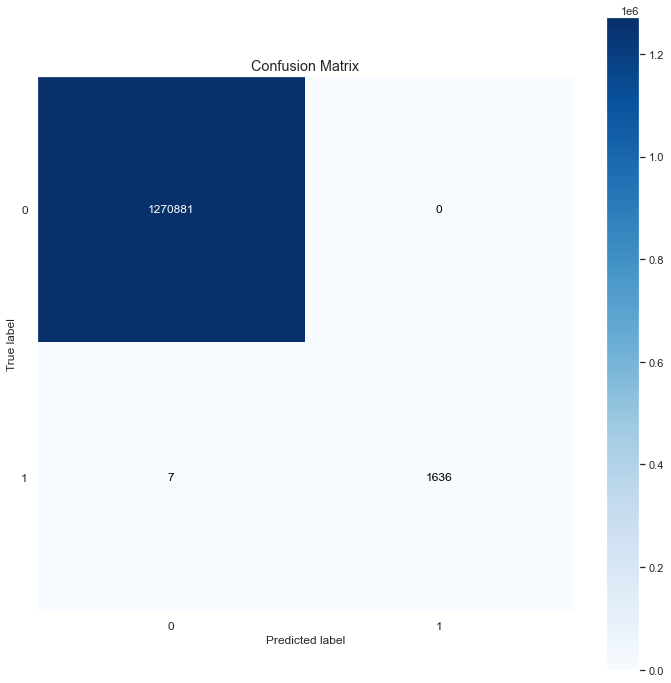

In [31]:
model_performance = model_metrics('XGBoost',y_test,yhat_xgb)

## 9.2. Random Forest

In [28]:
model_rf =  RandomForestClassifier(n_estimators=100,
                                   random_state=77).fit(x_train,y_train)

yhat_rf=model_rf.predict(x_test)

Accuracy: 0.9999937132816356
Balanced Accuracy: 0.9975654290931224
Kappa Score: 0.9975563400981207
Precision Score: 0.9951308581862447
Recall Score: 0.9951308581862447
F1 Score: 0.9975594874923733
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1270881
           1       1.00      1.00      1.00      1643

    accuracy                           1.00   1272524
   macro avg       1.00      1.00      1.00   1272524
weighted avg       1.00      1.00      1.00   1272524



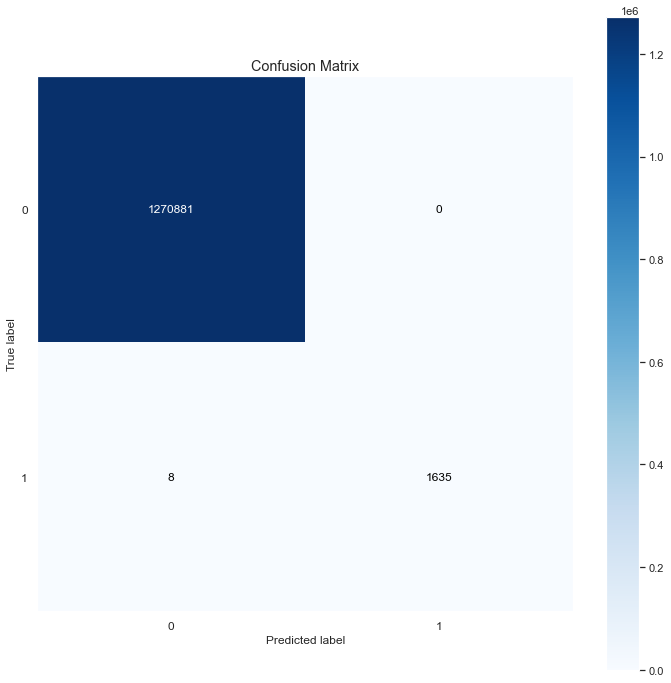

In [29]:
model_performance = model_metrics('Random Forest',y_test,yhat_rf)

# 10.0. Final Model

The models performance were similar, beeing "Random Forest Model" with 99,51% of Precision/Recall and "XGBoost Model" with 99,57% of Precision/Recall. However Random Forest presents best execution performance, executing about 33% faster then "XGBoost". The pickle exports of "Random Forest" also show significantily smaller, beeign 78% smaller then "XGBoost". So we'll continue with "Random Forest Model".

In [ ]:
#pickle.dump( model_xgb, open ( '../model/model_xgb.pkl' ,'wb') )

In [34]:
pickle.dump( model_rf, open ( '../model/model_rf.pkl' ,'wb') )

# Business Performance

In [30]:
x_test['isFraudPredict']=yhat_rf
x_test['isFraud']=y_test

In [53]:
trueFraudDetected=x_test[(x_test['isFraud']==1) & (x_test['isFraudPredict']==1)]
falseFraudDetected=x_test[(x_test['isFraud']==0) & (x_test['isFraudPredict']==1)]
fraudNotDetected=x_test[(x_test['isFraud']==1) & (x_test['isFraudPredict']==0)]
totalFraud=x_test[(x_test['isFraud']==1)] 

In [74]:
fraudsDetectectAmount=trueFraudDetected[['amount']].sum()
falseFraudsDetectedAmount=falseFraudDetected[['amount']].sum()
fraudsNotDetecetedAmount=fraudNotDetected[['amount']].sum()
fraudsAmount=totalFraud[['amount']].sum()
totalBill=fraudsDetectectAmount[0]*0.25 + falseFraudsDetectedAmount[0]*0.05 - fraudsNotDetecetedAmount[0]
totalAvoid=fraudsDetectectAmount[0]*0.75+fraudsNotDetecetedAmount[0]

In [77]:
print('Total fraud in Dataset: R$ {:,.2f}'.format(fraudsAmount[0]))
print('Total fraud detected: R$ {:,.2f}' .format(fraudsDetectectAmount[0]))
print('Total false fraud detected: R$ {:,.2f}'.format(falseFraudsDetectedAmount[0]))
print('Total fraud not detected: R$ {:,.2f}'.format(fraudsNotDetecetedAmount[0]))
print()
print()
print('Total bill Customer: R$ {:,.2f}'.format(totalBill))
print('Total avoid Client: R$ {:,.2f}'.format(totalAvoid))


Total fraud in Dataset: R$ 2,507,288,036.22
Total fraud detected: R$ 2,504,426,229.95
Total false fraud detected: R$ 0.00
Total fraud not detected: R$ 2,861,806.27


Total bill Customer: R$ 623,244,751.22
Total avoid Client: R$ 1,881,181,478.73


In test data set have 1.272.524 transcation, being 1643 frauds transactions, totalizing $2,507,288,036.22$ of frauds. 

Our model is able to detected 99,51 percent of all frauds, avoiding $ 2,504,426,229.95$ of frauds.

Frauds not detected by our model, totalize 0,49 percentl of all frauds, not avoiding $2,861,806.27$ of frauds. All this amount will be refound to customer.

In our bussiness strategy, we are able to generate a economy of $1,881,181,478.73$ **to customer**, generating a revenue of $623,244,751.22$ to **Blocker Fraud Company**.